# Measuring ICM morphology for the LoVoCCS sample

Here we measure the centroid coordinate and position angle of the intra-cluster medium X-ray emission of the LoVoCCS sample. The centroid is the first moment of the 2D surface brightness distribution (the average position, weighted by the surface brightness) and acts as an alternate (to the peak) definition of the central coordinate - it is also useful when combined with the peak, allowing for the creation of a metric for cluster disturbedness (a word I suspect I just made up).

The second moment of the 2D surface brightness distribution is essentially the covariance matrix, which can then be diagonalised to find the rotation angle (which can be turned into a position angle) and the axis length ratio of the (assumed) ellipse that describes the ICM emission.

We also measure the centroid shift ($w$), which is a standard measure of relaxation for galaxy clusters, and the concentration index ($c$) which is a measure of the fraction of ICM emission coming from the core of the cluster, and is a diagnostic for cool-core systems (in and of itself another relaxation measure, as cool-core clusters are generally relaxed because they have not experienced recent merger activity).

## Import Statements

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
from astropy.units import Quantity, UnitConversionError
from astropy.cosmology import LambdaCDM
from shutil import rmtree
import os
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse, FancyArrow
from matplotlib.ticker import FuncFormatter

# This adds the directory above to the path, allowing me to import the common functions that I've written in
#  common.py - this just saves me repeating boring code and makes sure its all consistent
import sys
sys.path.insert(0, '..')
from common import lovoccs_cosmo

import xga
xga.NUM_CORES = 10
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.sourcetools import ang_to_rad

# We will ignore some divide by invalid value warnings here - I promise its fine
np.seterr(divide='ignore', invalid='ignore')

%matplotlib inline

## Setting up necessary directories

Here we ensure that the directories we need to store the outputs in have been created:

In [2]:
fix_ap_dist_path = "../../outputs/figures/positions_and_morphology/centroid_posang/fixed_aperture_centroid_posang_dists/"
os.makedirs(fix_ap_dist_path, exist_ok=True)

multi_ap_dist_path = "../../outputs/figures/positions_and_morphology/centroid_posang/multi_aperture_centroid_posang_dists/"
os.makedirs(multi_ap_dist_path, exist_ok=True)

coords_morph_out_path = "../../outputs/result_files/positions_and_morphology/"
os.makedirs(coords_morph_out_path, exist_ok=True)

centroid_posang_vis_path = "../../outputs/cluster_visualisations/centroid_posangle_meas/"
os.makedirs(centroid_posang_vis_path, exist_ok=True)

## Defining any useful functions

Specifically, this is where we define the function that measures the centroid coordinate and the position angle of the ICM distribution - this will be included into XGA at some point, but for now we use this function:

In [3]:
def centroid_shape_estimate(rel_src, ap_rads, cent_coord=None, num_samp=100, 
                            back_inn_rad=None, back_out_rad=None):
    
    if ap_rads is None or ap_rads.isscalar:
        ap_rads = [ap_rads]
    
    if any([back_inn_rad is None, back_out_rad is None, ap_rads[0] is None]):
        back_sub = False
    else:
        back_sub = True
        back_mask = src.get_custom_mask(back_out_rad, back_inn_rad, remove_interlopers=True, 
                                        central_coord=cent_coord)    
    
    cur_rt = src.get_combined_ratemaps()
    data_cp = cur_rt.data.copy()
    
    cont_mask = src.get_interloper_mask()
    
    if back_sub:
        # Find the total mask areas. As the mask is just an array of ones and zeros we can just sum the
        #  whole thing to find the total pixel area covered.
#         src_area = (tot_mask * cur_rt.sensor_mask).sum()
        back_area = (back_mask * cur_rt.sensor_mask).sum()
        
        # Calculate an area normalisation so the background counts can be scaled to the source counts properly
#         area_norm = src_area / back_area
        
#         cur_rt.view(mask=back_mask, zoom_in=True)
        back_rt = np.sum(data_cp*back_mask)/back_area

        data_cp = data_cp - back_rt
        data_cp[data_cp < 0] = 0
    
    if num_samp != 0:
        rng = np.random.default_rng()
#         *tot_mask[..., None]
        all_resamp_msk_data = np.repeat((data_cp*cont_mask)[:, :, np.newaxis], num_samp, axis=2)
        # Resampling the count maps
        all_resamp_msk_data = rng.poisson(all_resamp_msk_data*cur_rt.expmap.data[..., None]) / cur_rt.expmap.data[..., None]
        all_resamp_msk_data[np.isnan(all_resamp_msk_data)] = 0
    
    returns = []
    for ap_rad in ap_rads:
        
        if ap_rad is not None:
            ap_mask = src.get_custom_mask(ap_rad, remove_interlopers=False, central_coord=cent_coord)
        else:
            ap_mask = np.ones(cur_rt.shape)
        
        tot_mask = ap_mask*cont_mask
        
        msk_data = data_cp*tot_mask

        norm_data = msk_data / msk_data.sum()

        arr_x, arr_y = np.meshgrid(np.arange(0, norm_data.shape[1], ), np.arange(0, norm_data.shape[0]))

        x_cen_pix = (norm_data*arr_x).sum()
        y_cen_pix = (norm_data*arr_y).sum()
        cen_pix = [x_cen_pix, y_cen_pix]
        cen_pix_quan = Quantity(cen_pix, 'pix')

        covar = np.zeros((2, 2))
        covar[0, 0] = (norm_data*np.square(arr_x - cen_pix[0])).sum()
        covar[1, 1] = (norm_data*np.square(arr_y - cen_pix[1])).sum()
        covar[0, 1] = (norm_data * (arr_x - cen_pix[0]) * (arr_y - cen_pix[1])).sum()
        covar[1, 0] = covar[0, 1]

        # TODO Try to normalise this output + ensure that it is North of East (does my head in)
        theta = 0.5*np.arctan((2*covar[1, 0]) / (covar[0, 0]-covar[1, 1]))*(180/np.pi)
        mod_theta = theta % 360
        if ((covar[1, 0] > 0 and (covar[0, 0] - covar[1, 1]) < 0) or 
                (covar[1, 0] < 0 and (covar[0, 0] - covar[1, 1]) < 0)):
            mod_theta = mod_theta - 90

        # This turns it (hopefully) from an angle defined from the usual axis (which matplotlib takes as an
        #  angle argument for its ellipse patch) to a position angle defined east from north
        # mod_theta = mod_theta - 90

        # This chunk should normalise the degenerate rotation angles to a range of -90 to 90. First of
        #  all ensure that the angles are within 0-360 degrees
        mod_theta = mod_theta%360
        
        # Quickly put the angles in radians
        rad_mod_theta = np.deg2rad(mod_theta)
        
        # Then we can use this trick, of creating a unit vector for the current angles (sin(theta), cos(theta)), and
        #  the arctan2 function which finds the quadrant of the angle by considering the sign, to restrict to 
        #  -180 to 180 degrees.
        rad_mod_theta = np.arctan2(np.sin(rad_mod_theta), np.cos(rad_mod_theta))

        # At this point, any angle outside of our desired -90 to 90 range will be degenerate (at least as we're thinking
        #  about the rotation of the semi-major axis of an ellipse) with an angle within that range, and we can 
        #  simply subtract or add 180 to bring it within the range
        # Above the target range
        if rad_mod_theta > (np.pi/2):
            rad_mod_theta = rad_mod_theta - np.pi
        elif rad_mod_theta < (-np.pi/2):
            rad_mod_theta = rad_mod_theta + np.pi

        # Then we convert back to degrees
        mod_theta = np.rad2deg(rad_mod_theta)

        eig_pl = ((covar[0, 0] + covar[1, 1]) + np.sqrt((covar[0, 0] - covar[0, 0])**2 + 4*covar[0, 1]**2)) / 2
        eig_mi = ((covar[0, 0] + covar[1, 1]) - np.sqrt((covar[0, 0] - covar[0, 0])**2 + 4*covar[0, 1]**2)) / 2

        x_s = np.sqrt(eig_pl)
        y_s = np.sqrt(eig_mi)

        # If the number of re-samples requested is zero, we end the function here and return (did it like this 
        #  because many of the bits of math using the resampled cov matrix are long and indenting them further 
        #  does not sound like fun)
        if num_samp == 0:
            returns.append([cur_rt.coord_conv(cen_pix_quan, 'deg'), mod_theta, x_s, y_s, None, None, None, None])
            continue
        
        resamp_msk_data = all_resamp_msk_data*tot_mask[..., None]
        resamp_norm_data = resamp_msk_data / resamp_msk_data.sum(axis=(0, 1))

        x_cen_pix_resamp_dist = (resamp_norm_data*arr_x[..., None]).sum(axis=(0, 1))
        y_cen_pix_resamp_dist = (resamp_norm_data*arr_y[..., None]).sum(axis=(0, 1))
        cen_pix_resamp_dist = Quantity([x_cen_pix_resamp_dist, y_cen_pix_resamp_dist], 'pix').T
        cen_deg_resamp_dist = cur_rt.coord_conv(cen_pix_resamp_dist, 'deg')


        resamp_covar = np.zeros((2, 2, num_samp))

        resamp_covar[0, 0, :] = (resamp_norm_data*np.square(arr_x[..., None] - 
                                                            cen_pix_resamp_dist[:, 0].value)).sum(axis=(0, 1))
        resamp_covar[1, 1, :] = (resamp_norm_data*np.square(arr_y[..., None] - 
                                                            cen_pix_resamp_dist[:, 1].value)).sum(axis=(0, 1))

        resamp_covar[0, 1, :] = ((resamp_norm_data*(arr_x[..., None] - cen_pix_resamp_dist[:, 0].value)*
                                  (arr_y[..., None] - cen_pix_resamp_dist[:, 1].value)).sum(axis=(0, 1)))
        resamp_covar[1, 0, :] = resamp_covar[0, 1, :]

        theta_dist = (0.5*np.arctan((2*resamp_covar[1, 0, :]) / 
                                    (resamp_covar[0, 0, :]-resamp_covar[1, 1, :]))*(180/np.pi))
        mod_theta_dist = theta_dist % 360

        rot_bool = (((resamp_covar[1, 0, :] > 0) & ((resamp_covar[0, 0, :] - resamp_covar[1, 1, :]) < 0)) | 
                    ((resamp_covar[1, 0, :] < 0) & ((resamp_covar[0, 0, :] - resamp_covar[1, 1, :]) < 0)))
        mod_theta_dist = mod_theta_dist - (np.full(num_samp, 90)*rot_bool)

        # mod_theta_dist = mod_theta_dist - 90
        
        # This chunk should normalise the degenerate rotation angles to a range of -90 to 90. First of
        #  all ensure that the angles are within 0-360 degrees
        mod_theta_dist = mod_theta_dist%360
        
        # Quickly put the angles in radians
        rad_mod_theta_dist = np.deg2rad(mod_theta_dist)
        
        # Then we can use this trick, of creating a unit vector for the current angles (sin(theta), cos(theta)), and
        #  the arctan2 function which finds the quadrant of the angle by considering the sign, to restrict to 
        #  -180 to 180 degrees.
        rad_mod_theta_dist = np.arctan2(np.sin(rad_mod_theta_dist), np.cos(rad_mod_theta_dist))

        # At this point, any angle outside of our desired -90 to 90 range will be degenerate (at least as we're thinking
        #  about the rotation of the semi-major axis of an ellipse) with an angle within that range, and we can 
        #  simply subtract or add 180 to bring it within the range
        # Above the target range
        abv_range = np.argwhere(rad_mod_theta_dist > (np.pi/2)).flatten()
        rad_mod_theta_dist[abv_range] = rad_mod_theta_dist[abv_range]-np.pi
        # Below the target range
        blw_range = np.argwhere(rad_mod_theta_dist < (-np.pi/2)).flatten()
        rad_mod_theta_dist[blw_range] = rad_mod_theta_dist[blw_range]+np.pi

        # Then we convert back to degrees
        mod_theta_dist = np.rad2deg(rad_mod_theta_dist)

        eig_pl_dist = (((resamp_covar[0, 0, :] + resamp_covar[1, 1, :]) + 
                        np.sqrt((resamp_covar[0, 0, :] - resamp_covar[0, 0, :])**2 + 4*resamp_covar[0, 1, :]**2)) / 2)
        eig_mi_dist = (((resamp_covar[0, 0, :] + resamp_covar[1, 1, :]) - 
                        np.sqrt((resamp_covar[0, 0, :] - resamp_covar[0, 0, :])**2 + 4*resamp_covar[0, 1, :]**2)) / 2)

        x_s_dist = np.sqrt(eig_pl_dist)
        y_s_dist = np.sqrt(eig_mi_dist)

        returns.append([cur_rt.coord_conv(cen_pix_quan, 'deg'), mod_theta, x_s, y_s, cen_deg_resamp_dist, mod_theta_dist, \
            x_s_dist, y_s_dist])
    
    # This is ugly and inefficient and I do not care
    if len(returns) == 1:
        returns = returns[0]
    else:
        new_returns = [[], [], [], [], [], [], [], []]      
        for ap_ret in returns:
            for ret_ind, ret_en in enumerate(ap_ret):
                new_returns[ret_ind].append(ret_en)
        returns = new_returns
    
    return returns


def haversine(ra1, dec1, ra2, dec2):
    """
    Simple function to calculate the Haversine distance between two coordinates.

    :param ra1: The RA of the first coordinate.
    :param dec1: The declination of the first coordinate.
    :param ra2: The RA of the second coordinate.
    :param dec2: The declination of the second coordinate.
    """
    hav_sep = 2 * np.arcsin(np.sqrt((np.sin(((dec1*(np.pi / 180))-(dec2*(np.pi / 180))) / 2) ** 2)
                                    + np.cos((dec2 * (np.pi / 180))) * np.cos(dec1 * (np.pi / 180))
                                    * np.sin(((ra1*(np.pi / 180)) - (ra2*(np.pi / 180))) / 2) ** 2))
    # Converting back to degrees from radians
    hav_sep /= (np.pi / 180)
    hav_sep = Quantity(hav_sep, 'deg').to('arcmin')
    
    return hav_sep

## Reading in the sample

We read in the LoVoCCS sample relevant to the current work:

In [4]:
samp = pd.read_csv("../../sample_files/X-LoVoCCSI.csv")
samp['LoVoCCS_name'] = samp['LoVoCCSID'].apply(lambda x: "LoVoCCS-" + str(x))
samp

LoVoCCSID common_name    start_ra  start_dec  MCXC_Redshift  MCXC_R500  \
0          1       A2029  227.734300   5.745471         0.0766     1.3344   
1          2        A401   44.740000  13.580000         0.0739     1.2421   
2         4A    A85North   10.458750  -9.301944         0.0555     1.2103   
3         4B    A85South   10.451487  -9.460007         0.0555     1.2103   
4          5       A3667  303.157313 -56.845978         0.0556     1.1990   
..       ...         ...         ...        ...            ...        ...   
62       121       A3128   52.466189 -52.580728         0.0624     0.8831   
63       122       A1023  157.000000  -6.800000         0.1176     0.8553   
64       123       A3528  193.670000 -29.220000         0.0544     0.8855   
65       131        A761  137.651250 -10.581111         0.0916     0.8627   
66       134       A3825  329.604682 -60.413676         0.0750     0.8685   

      MCXC_RA   MCXC_DEC  manual_xray_ra  manual_xray_dec  MCXC_Lx500_0.1_2.4  \
0   227.73000   5.720000      227.734300         5.745471        8.726709e+44   
1    44.74000  13.580000             NaN              NaN        6.088643e+44   
2    10.45875  -9.301944             NaN              NaN        5.100085e+44   
3    10.45875  -9.301944       10.451487        -9.460007        5.100085e+44   
4   303.13000 -56.830000      303.157313       -56.845978        4.871933e+44   
..        ...        ...             ...              ...                 ...   
62   52.50000 -52.600000       52.466189       -52.580728        1.101682e+44   
63  157.00000  -6.800000             NaN              NaN        1.095941e+44   
64  193.67000 -29.220000             NaN              NaN        1.093054e+44   
65  137.65125 -10.581111             NaN              NaN        1.063423e+44   
66  329.61000 -60.400000      329.604682       -60.413676        1.050267e+44   

   LoVoCCS_name  
0     LoVoCCS-1  
1     LoVoCCS-2  
2    LoVoCCS-4A  
3    LoVoCCS-4B  
4     LoVoCCS-5  
..          ...  
62  LoVoCCS-121  
63  LoVoCCS-122  
64  LoVoCCS-123  
65  LoVoCCS-131  
66  LoVoCCS-134  

[67 rows x 12 columns]

As we wish to calculate the centroid shift as part of this analysis, we also read in the previously-measured X-ray peak coordinates for the LoVoCCS sample:

In [5]:
peaks = pd.read_csv(coords_morph_out_path + "xmm_peak_coords.csv")
peaks

name     peak_ra   peak_dec
0     LoVoCCS-1  227.733253   5.745184
1     LoVoCCS-2   44.750675  13.594567
2     LoVoCCS-4   10.460369  -9.303375
3     LoVoCCS-5  303.100675 -56.851435
4     LoVoCCS-7  330.466217 -59.948751
..          ...         ...        ...
58  LoVoCCS-119  125.258572   7.863624
59  LoVoCCS-121   52.452404 -52.606815
60  LoVoCCS-123  193.669189 -29.227468
61  LoVoCCS-131  137.653101 -10.577569
62  LoVoCCS-134  329.615604 -60.414129

[63 rows x 3 columns]

## Defining an XGA ClusterSample

As we do not have observation cleaning turned on, we manually remove clusters that we know are excluded from our other analyses due to inadequate XMM data:

* LoVoCCS-41C is a component of 41 we identified from ROSAT Pointed data, but it does not fall on the XMM observation.
* LoVoCCS-33 is a cluster that partially falls on the edge of an observation of a nearby object - the coverage is insufficient for any real analysis however.

In [6]:
samp = samp[~samp['LoVoCCSID'].isin(['41C', '33'])]

We define a ClusterSample, centered on the 'start positions' we defined in the early stages of our analysis of this sample - the start positions will be the same as the MCXC positions in cases where we judged the coordinate to be adequate, but will be manually defined from modern observations if it was too far outside the main part of the ICM, or if the cluster has multiple components that went unresolved in MCXC:

In [7]:
srcs = ClusterSample(samp['start_ra'].values, samp['start_dec'].values, samp['MCXC_Redshift'].values, 
                     samp['LoVoCCS_name'].values, r500=Quantity(samp['MCXC_R500'].values, 'Mpc'), use_peak=False, 
                     clean_obs=False, cosmology=lovoccs_cosmo)
srcs.info()

Setting up Galaxy Clusters: 100%|██████████| 62/62 [02:37<00:00,  2.54s/it]


-----------------------------------------------------
Number of Sources - 62
Redshift Information - True
Sources with ≥1 detection - 60 [97%]
-----------------------------------------------------




/tmp/ipykernel_4018902/1780493561.py:1: UserWarning: The following do not appear to have any XMM data, and will not be included in the sample (can also check .failed_names); LoVoCCS-55, LoVoCCS-108, LoVoCCS-122
  srcs = ClusterSample(samp['start_ra'].values, samp['start_dec'].values, samp['MCXC_Redshift'].values,
/mnt/home/turne540/software/anaconda3/envs/xga_release/lib/python3.12/site-packages/xga/samples/extended.py:308: UserWarning: Non-fatal warnings occurred during the declaration of some sources, to access them please use the suppressed_warnings property of this sample.
  self._check_source_warnings()


## Measuring centroid & PA within a fixed aperture

First of all, we measure the centroid position within a fixed aperture that is centered on the 'start coordinate'. Any identified contaminating sources are removed, to try to avoid biasing the position - background from an annulus outside the aperture is subtracted. As a part of this analysis, we also measure the position angle and the axis ratio of the ellipse. 

Then, visualisations are generated (saved to disk in the 'outputs' section of this repository) and displayed (for a small subset to avoid making this notebook file too large). The centroid position is indicated by the solid cross-hair, and the start position by the dashed cross-hair; the white ellipse indicates the axis sizes (though it has been arbitrarily scaled up in size, the ratio of the axis lengths is the most useful thing), as well as its rotation.

We also attempt to quantify the statistical uncertainty on the quantities we measure here by resampling the count-rate map many times to produce posterior distributions of the properties - these are then used to calculate uncertainties (and the distribution histograms are saved to disk):

LoVoCCS-1


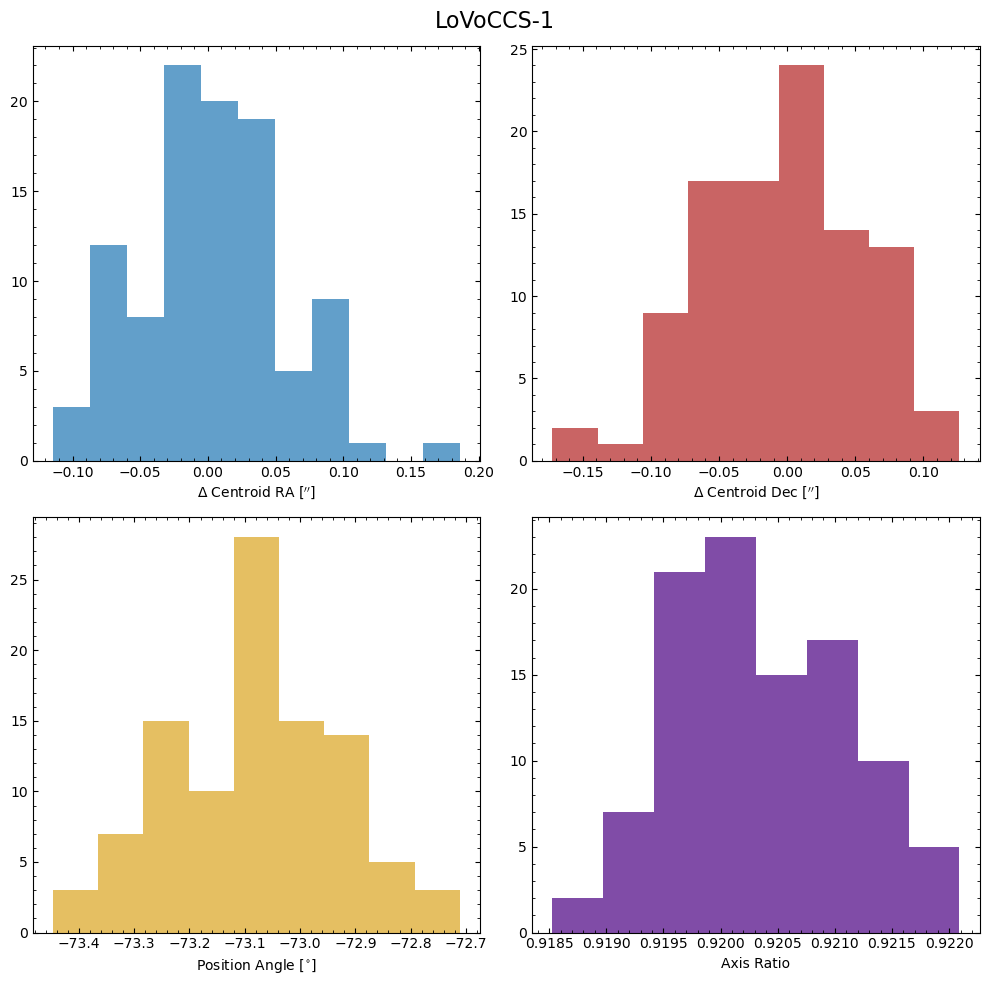

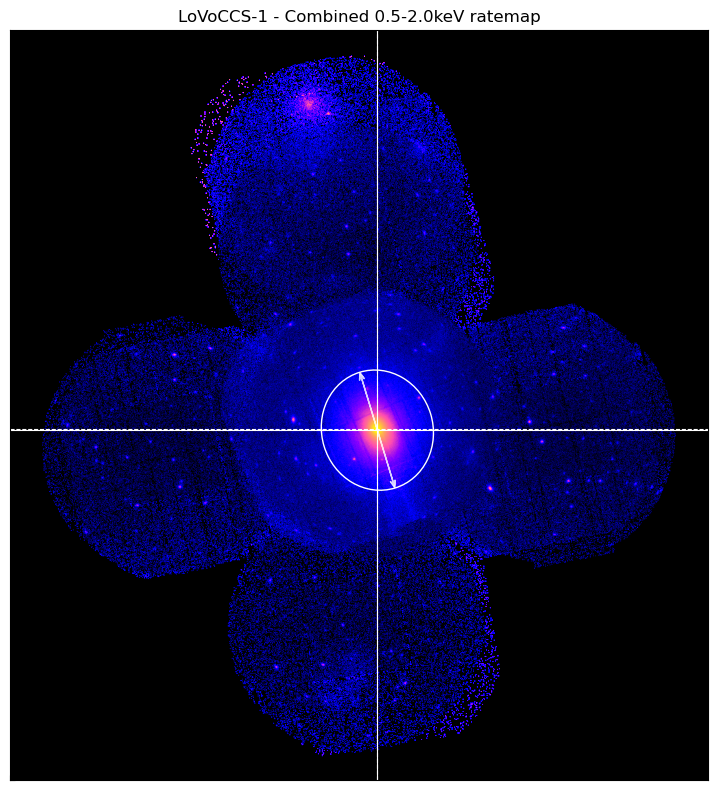

LoVoCCS-2


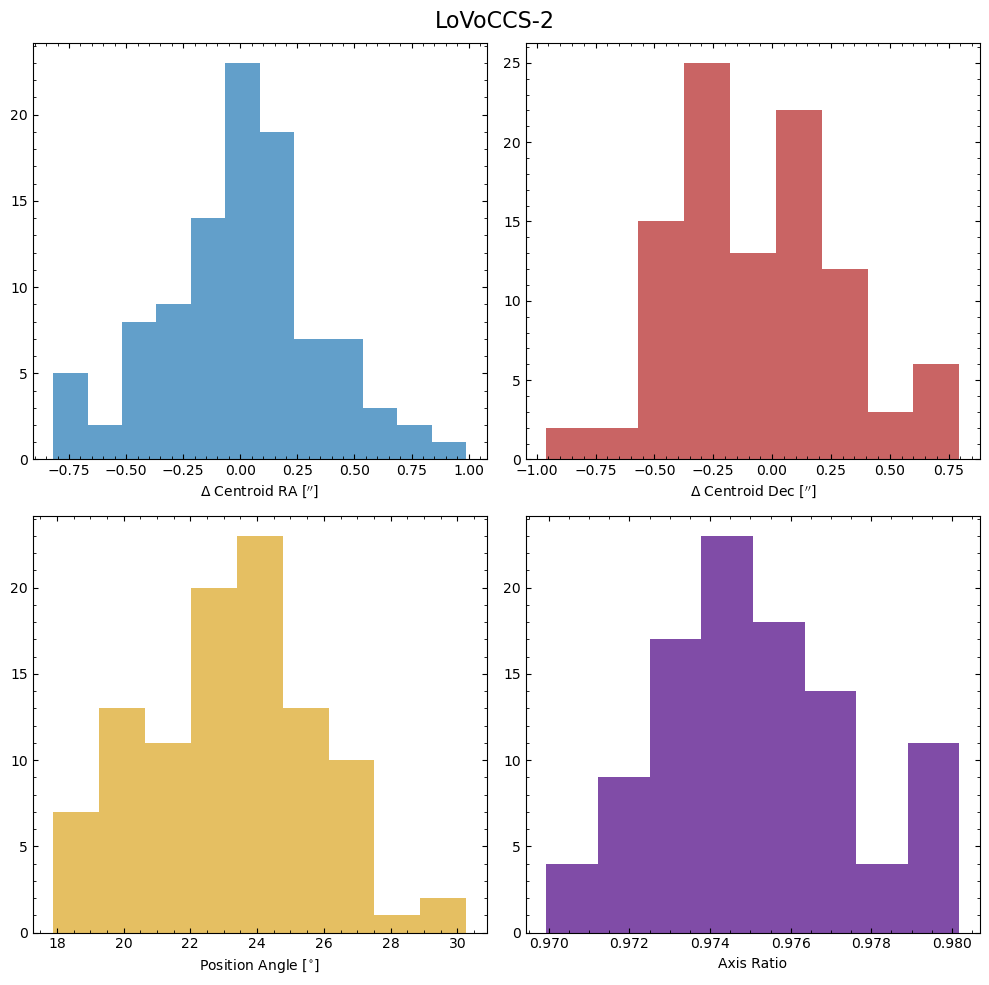

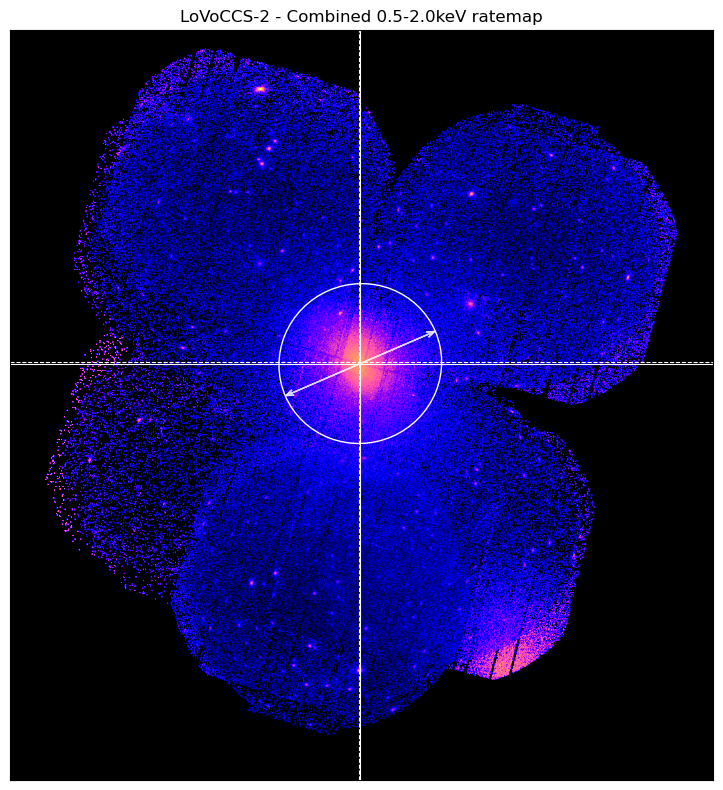

LoVoCCS-4A


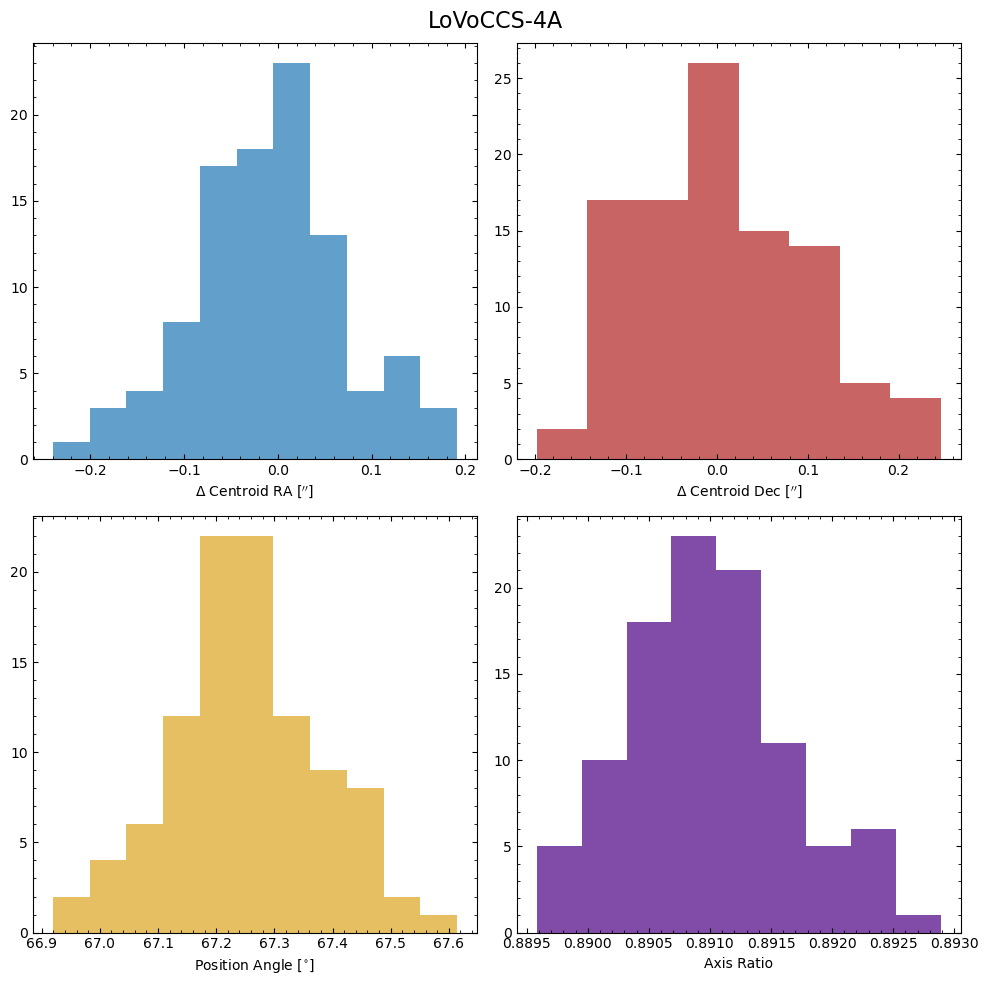

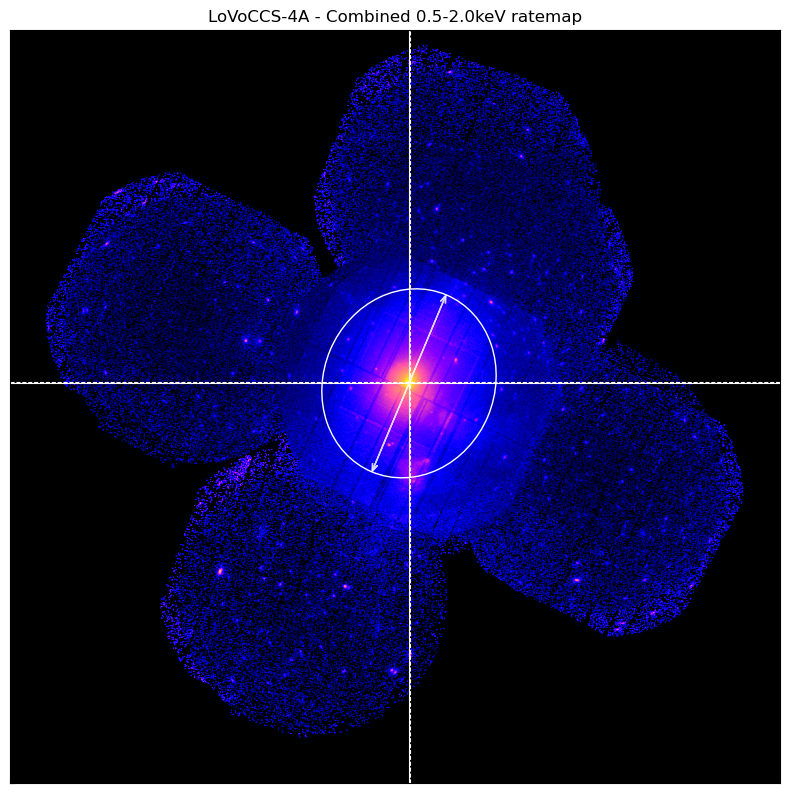

LoVoCCS-4B


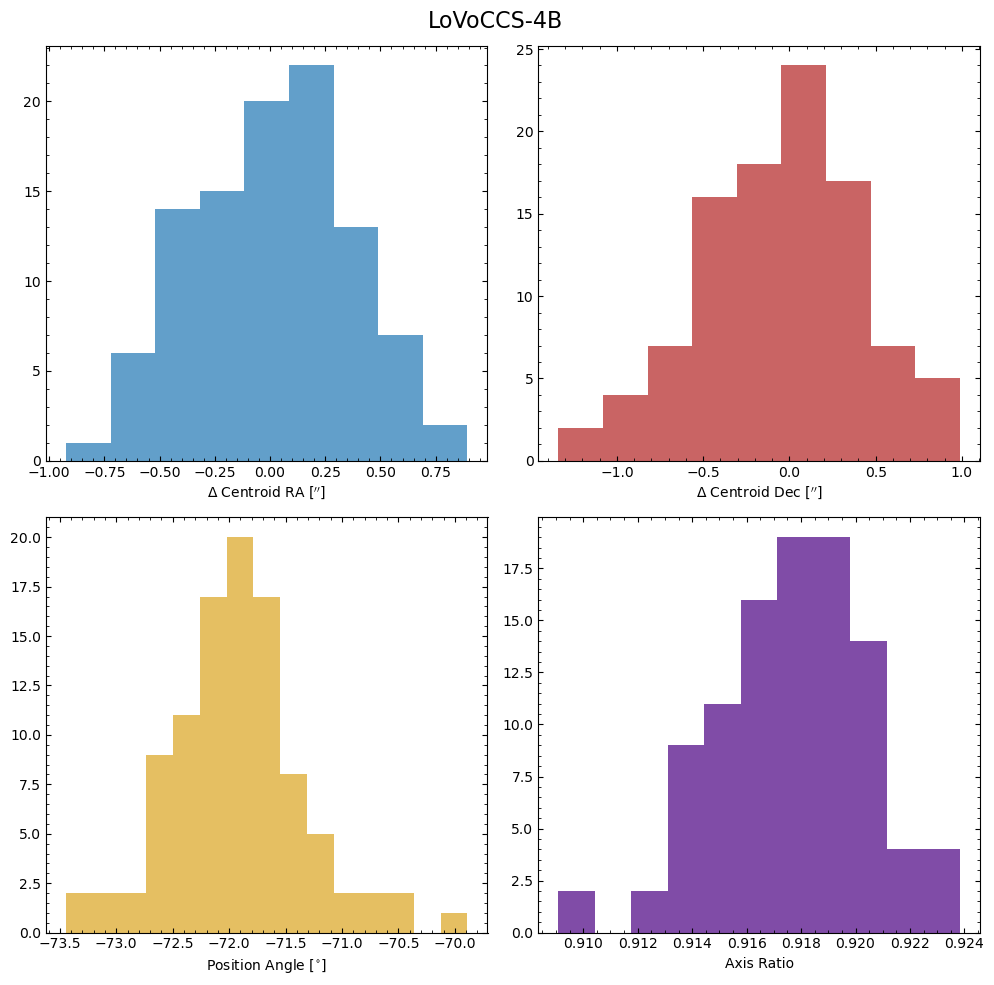

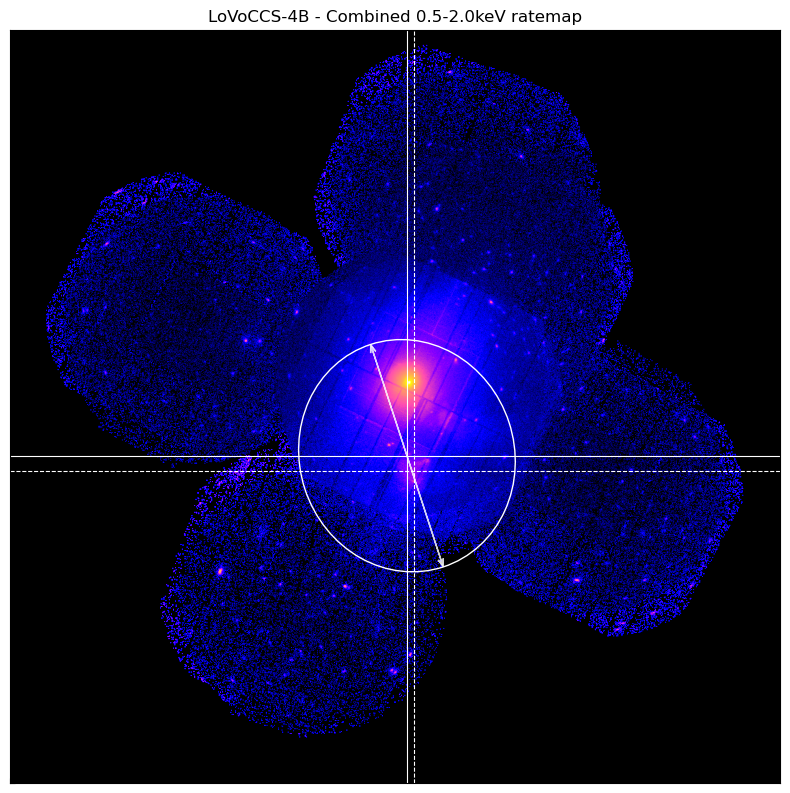

LoVoCCS-5


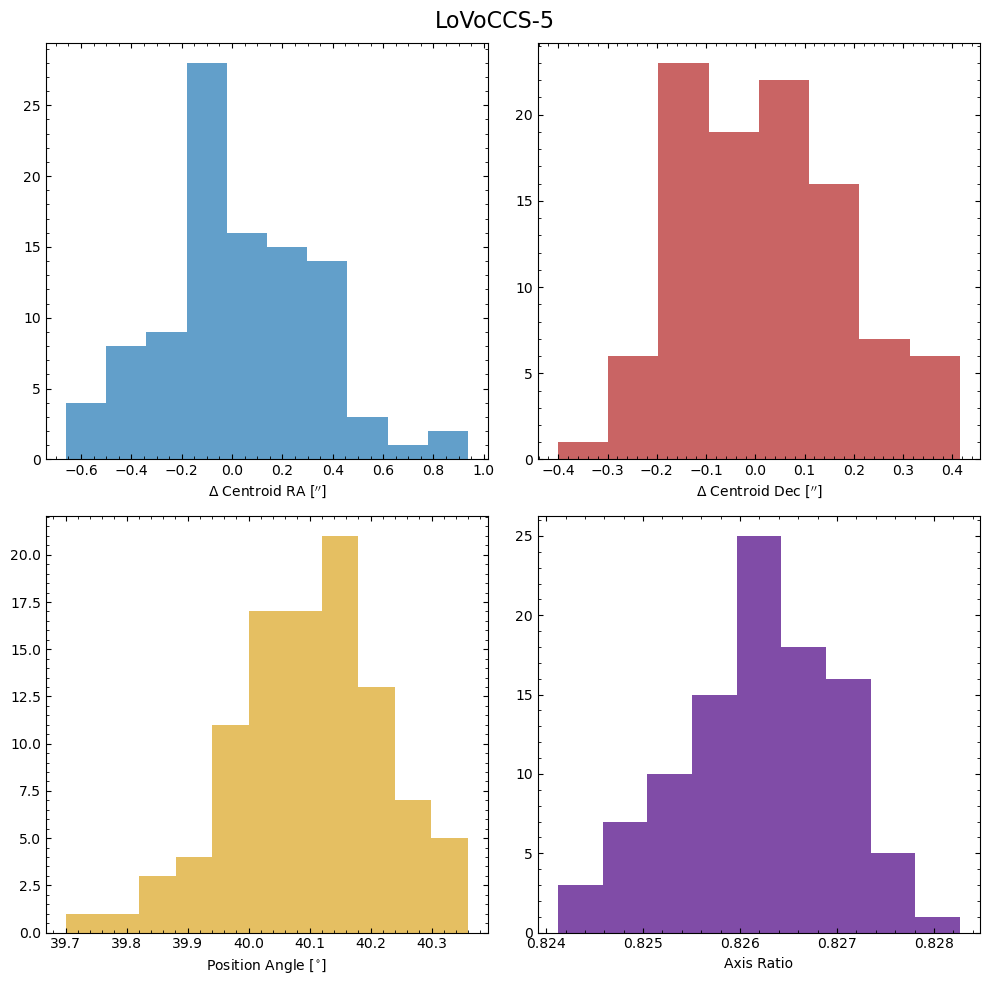

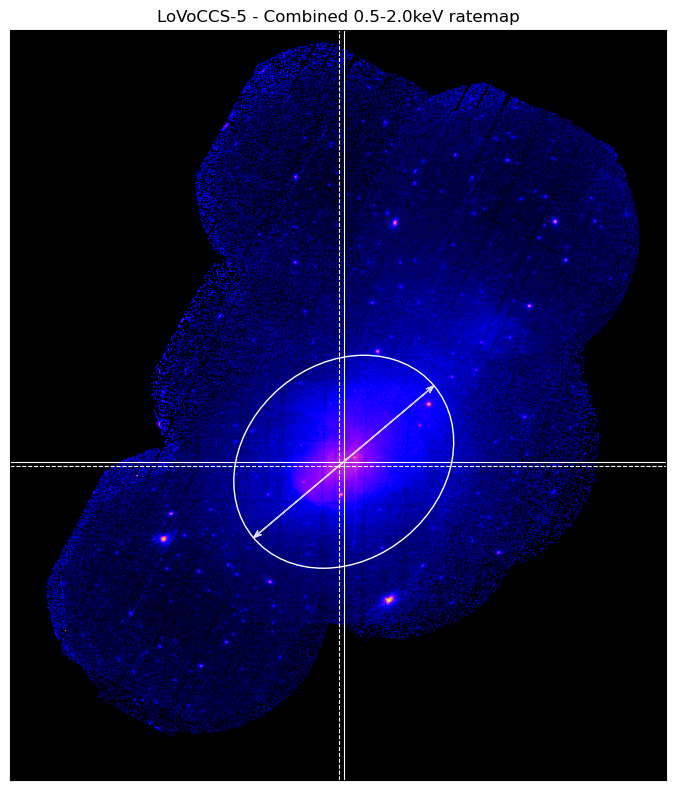

LoVoCCS-7


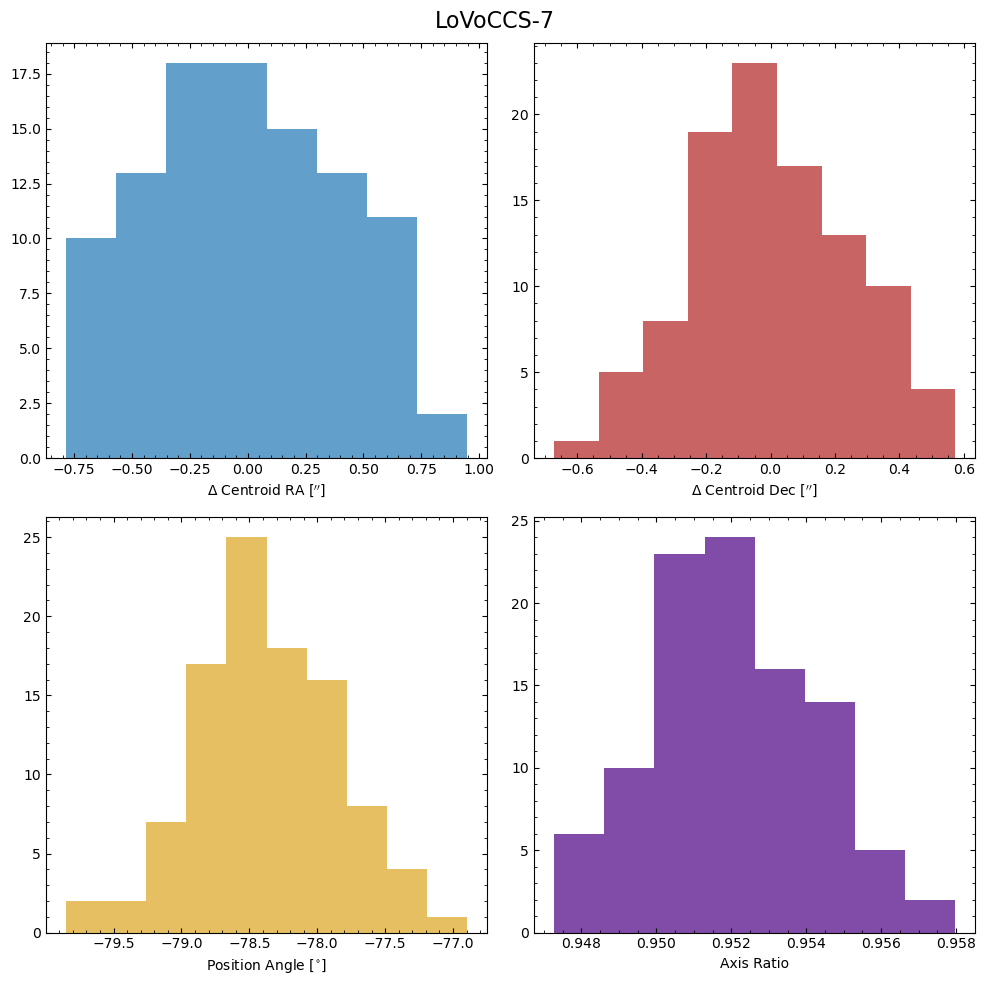

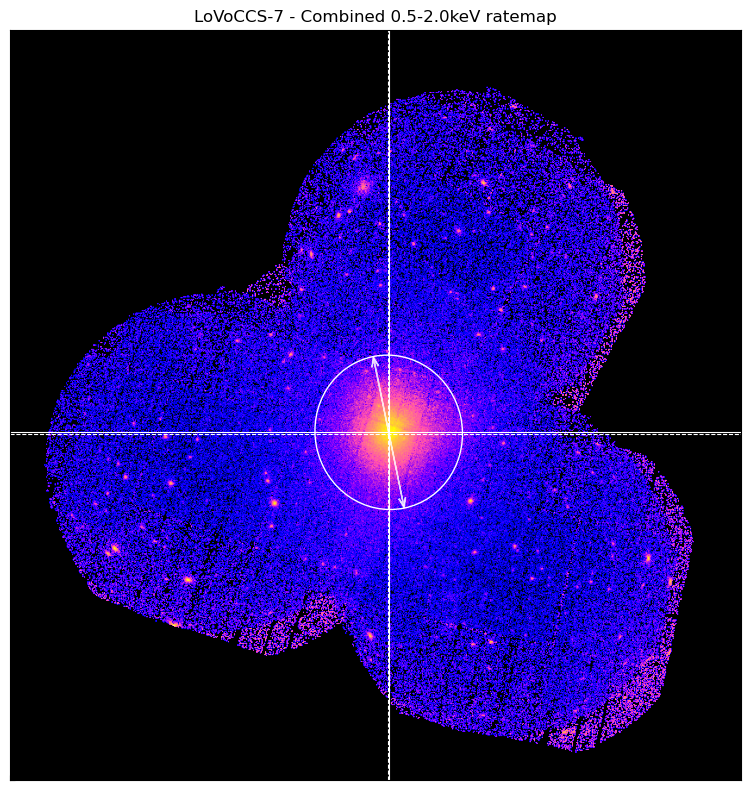

LoVoCCS-9


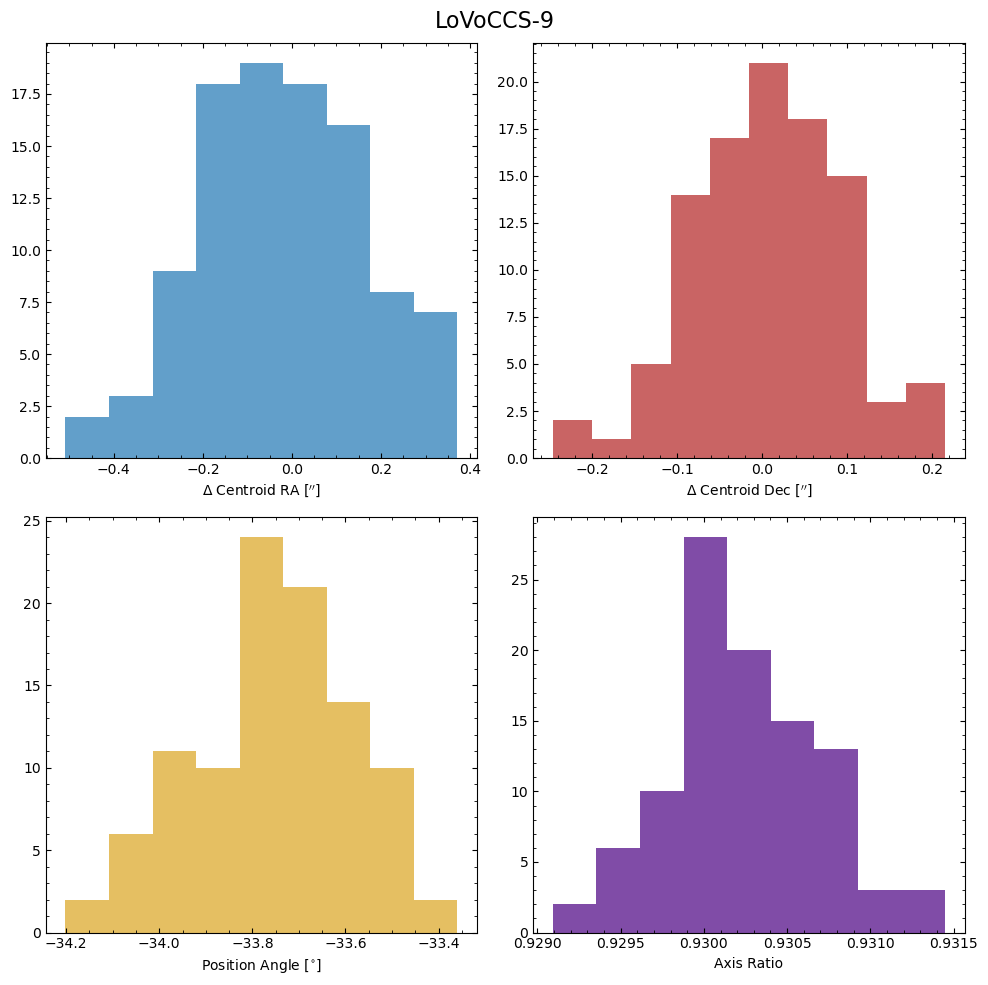

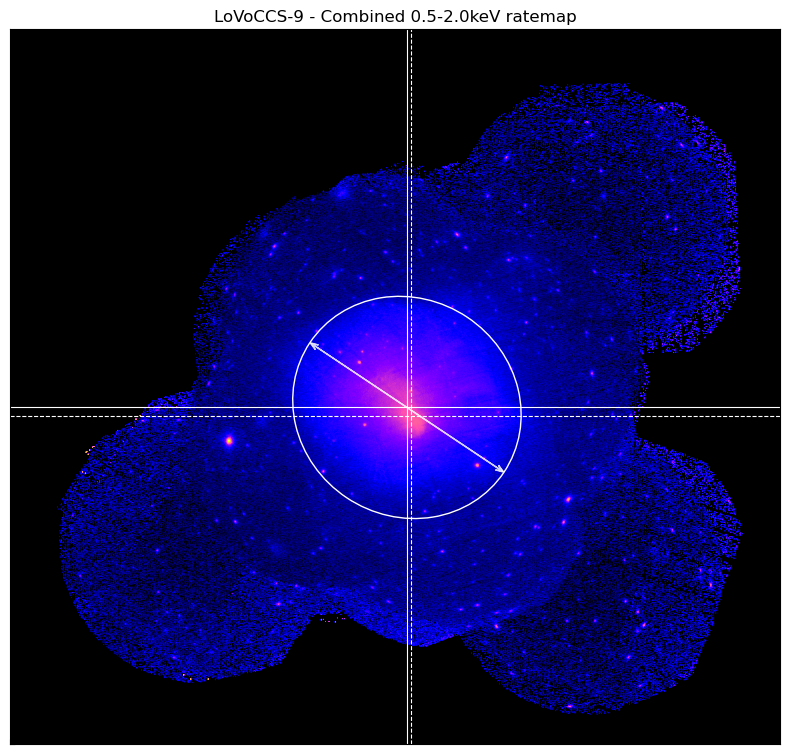

LoVoCCS-10


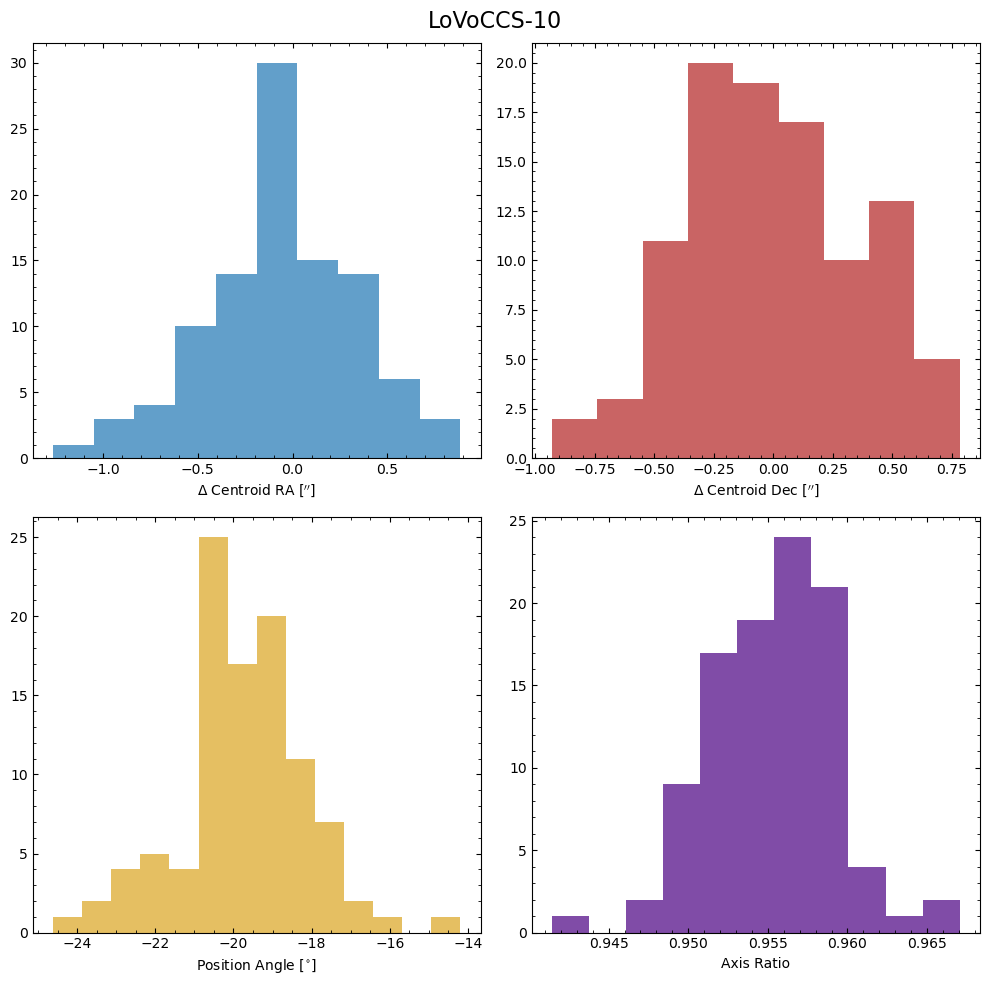

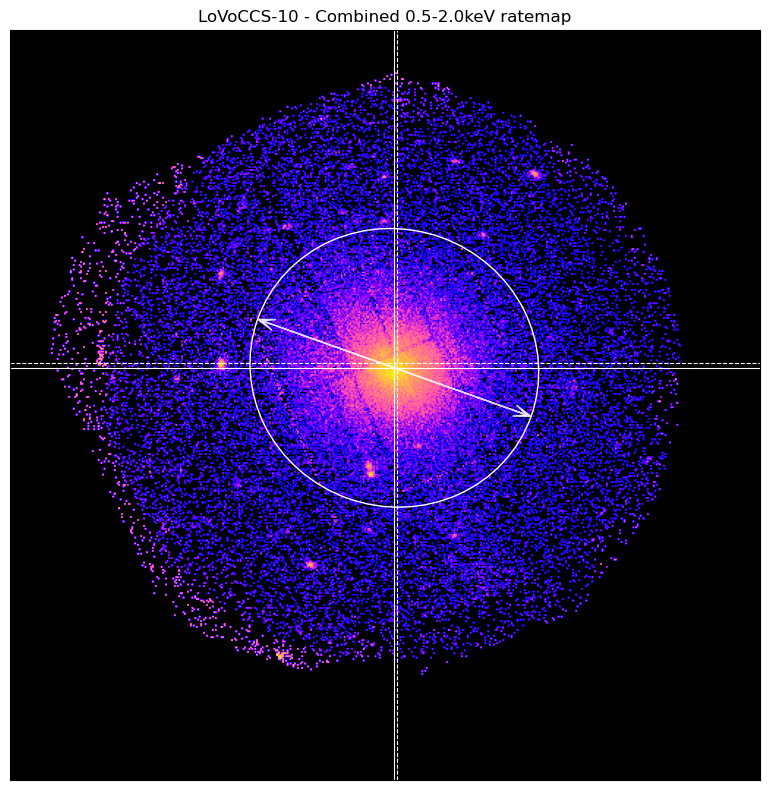

LoVoCCS-11


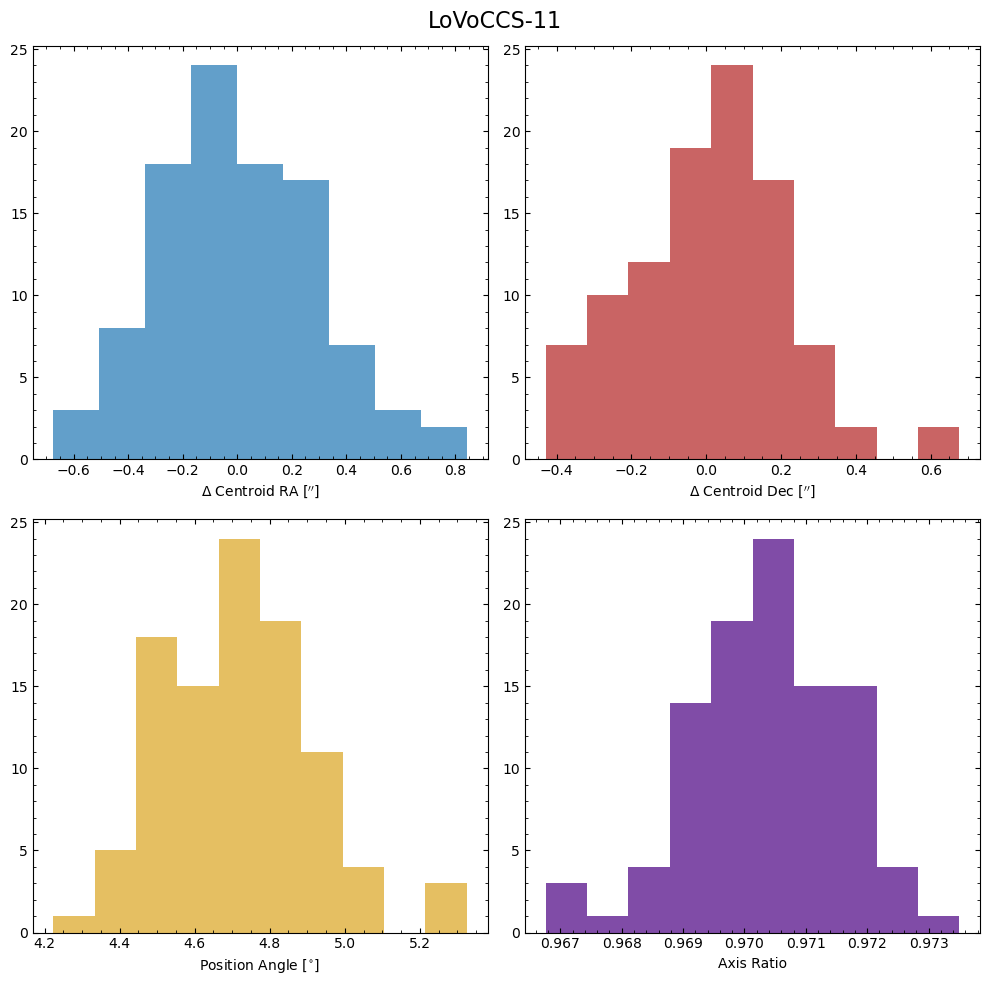

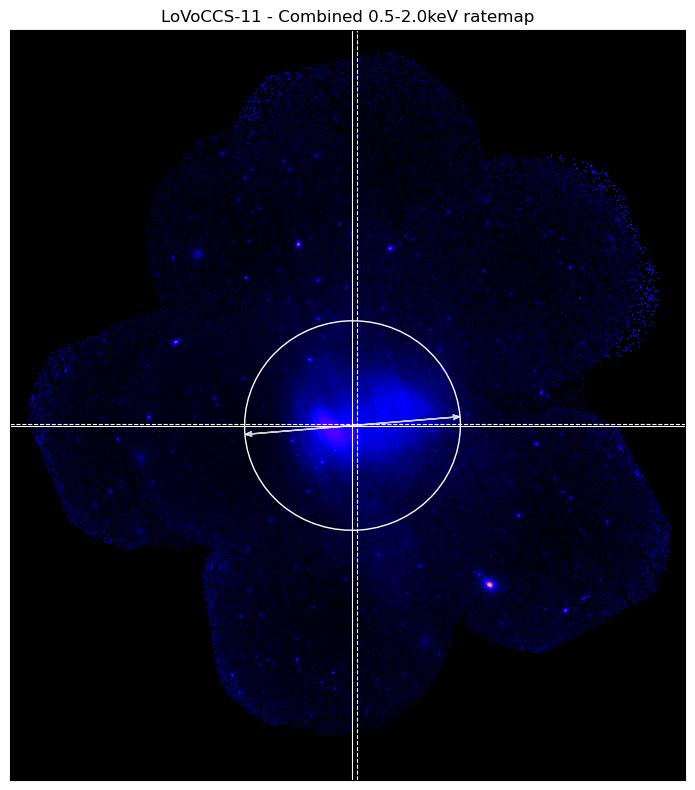

LoVoCCS-12


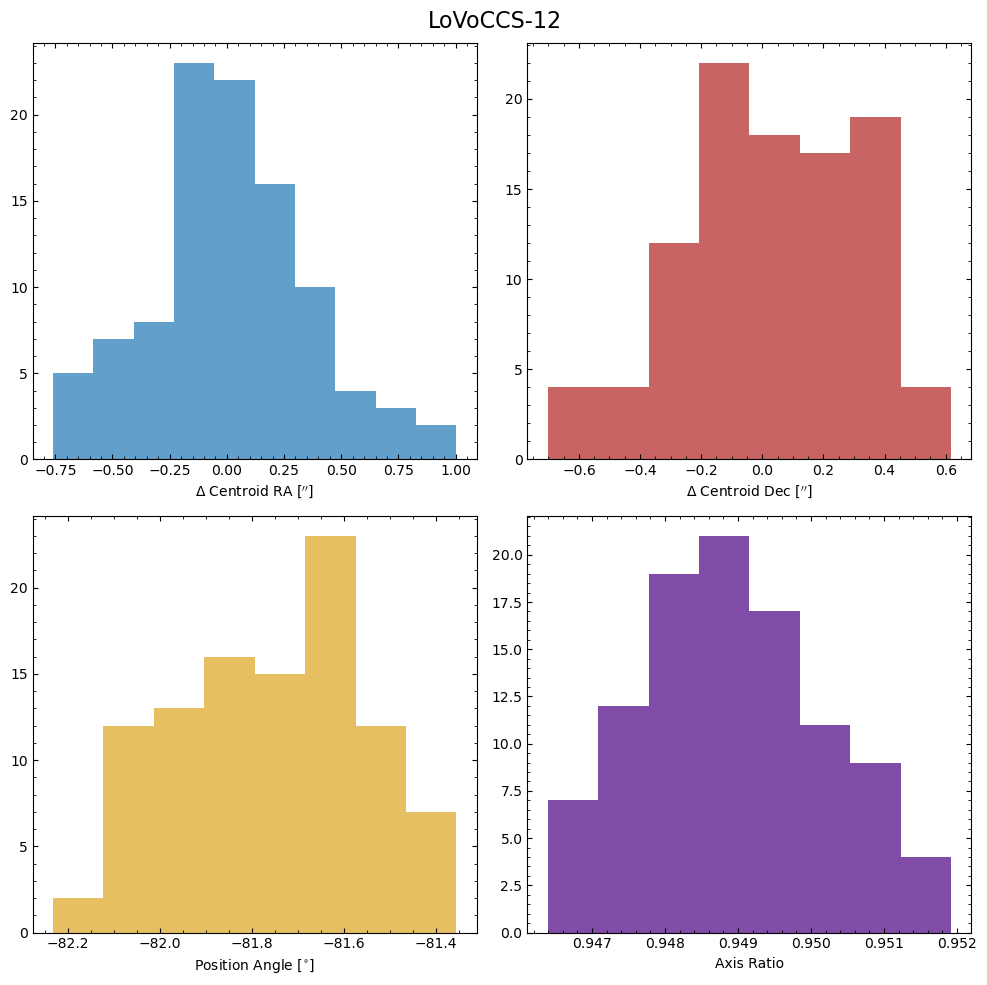

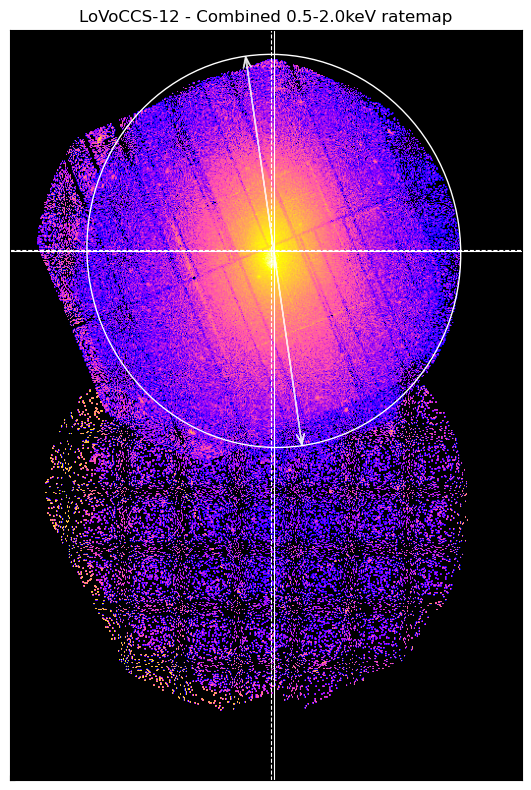

In [8]:
# The fixed aperture we're using
ap = Quantity(500, 'kpc')
# back_ap_inn = None
# back_ap_out = None
back_ap_inn = Quantity(800, 'kpc')
back_ap_out = Quantity(1000, 'kpc')

# This defines the number of times the count-rate map is resampled to calculate the statistical uncertainties
resamp = 100
# The confidence level for the extracted uncertainties
conf_level = 90

# We store our fixed-aperture measurements of centroid coordinate, position angle, and axis lengths here
fixed_ap_ra = {}
fixed_ap_dec = {}
fixed_ap_ang = {}
fixed_ap_rat = {}

# Iterating through all of our sources
for src_ind, src in enumerate(srcs):
    # This runs the centroid/PA calculation function defined near the top of the notebook. The returned position
    #  is in degrees, the PA should be defined East of North. We also return distributions of central coords, 
    #  position angle, and x/y scale, calculated from the resampled count-rate maps (the resamp variable defined
    #  how many there are)
    cur_cen, cur_pa, cur_x_scale, cur_y_scale, cur_cen_dist, cur_pa_dist, cur_x_scale_dist, \
        cur_y_scale_dist = centroid_shape_estimate(src, ap, num_samp=resamp, back_inn_rad=back_ap_inn, 
                                                   back_out_rad=back_ap_out) 
    
    # We can calculate confidence levels from the distributions of RA and Dec
    cen_median = np.percentile(cur_cen_dist, 50, axis=0).to('deg')
    cen_pl = np.percentile(cur_cen_dist, 50 + (conf_level/2), axis=0).to('deg') - cen_median
    cen_mi = cen_median - np.percentile(cur_cen_dist, 50 - (conf_level/2), axis=0).to('deg')

    # Same deal with the position angle, we calculate the upper and lower uncertainties at the specified
    #  confidence level 
    pa_median = np.percentile(cur_pa_dist, 50, axis=0)
    pa_pl = np.percentile(cur_pa_dist, 50 + (conf_level/2), axis=0) - pa_median
    pa_mi = pa_median - np.percentile(cur_pa_dist, 50 - (conf_level/2), axis=0)
    
    # Create distribution of axis ratios from the x and y scale distributions 
    rat_dist = np.min(np.array([(cur_x_scale_dist / cur_y_scale_dist), (cur_y_scale_dist / cur_x_scale_dist)]), 
                      axis=0)
    # Then we calculate the uncertainties the same way
    rat_median = np.percentile(rat_dist, 50, axis=0)
    rat_pl = np.percentile(rat_dist, 50 + (conf_level/2), axis=0) - rat_median
    rat_mi = rat_median - np.percentile(rat_dist, 50 - (conf_level/2), axis=0)
    
    # Store the results of this analysis in dictionaries for later
    fixed_ap_ra[src.name] = [cen_median[0], cen_mi[0], cen_pl[0]]
    fixed_ap_dec[src.name] = [cen_median[1], cen_mi[1], cen_pl[1]]
    fixed_ap_ang[src.name] = [pa_median, pa_mi, pa_pl]
    fixed_ap_rat[src.name] = [min([(cur_x_scale/cur_y_scale), (cur_y_scale/cur_x_scale)]), rat_mi, rat_pl]
    
    # We make some crude histograms of the output distributions of the different values we've measured, so
    #  they aren't lost forever - they will be saved to disk as well
    fig, ax_arr = plt.subplots(2, 2, figsize=(10, 10))
    
    for ax_ind, ax in np.ndenumerate(ax_arr):
        ax.minorticks_on()
        ax.tick_params(which='both', direction='in', top=True, right=True)
    
    # We just plot the histograms, nothing fancy - we also leave the bins to auto
    ax_arr[0, 0].hist((cur_cen_dist[:, 0]-cur_cen[0]).to("arcsec").value, bins='auto', 
                      histtype='stepfilled', label='RA', color='tab:blue', alpha=0.7)
    ax_arr[0, 0].set_xlabel(r"$\Delta$ Centroid RA [$^{\prime\prime}$]")
    
    ax_arr[0, 1].hist((cur_cen_dist[:, 1]-cur_cen[1]).to("arcsec").value, bins='auto', 
                      histtype='stepfilled', label='Dec', color='firebrick', alpha=0.7)
    ax_arr[0, 1].set_xlabel(r"$\Delta$ Centroid Dec [$^{\prime\prime}$]")
    
    ax_arr[1, 0].hist(cur_pa_dist, bins='auto', histtype='stepfilled', label='PA', 
                      color='goldenrod', alpha=0.7)
    ax_arr[1, 0].set_xlabel(r"Position Angle [$^{\circ}$]")
    
    ax_arr[1, 1].hist(rat_dist, bins='auto', histtype='stepfilled', label='Axis Ratio', 
                      color='indigo', alpha=0.7)
    ax_arr[1, 1].set_xlabel(r"Axis Ratio")
    
    # Add an overall title containing the name of the cluster
    plt.suptitle(src.name, fontsize=16)
    plt.tight_layout()
    # All histograms are saved
    file_name = "{n}_xmm_centroid_{a}kpc_prop_dists.pdf".format(n=src.name, a=ap.to('kpc').value.astype(int))
    plt.savefig(fix_ap_dist_path + file_name)
    # Only the first ten are shown here, to keep the size of the notebook down
    if src_ind < 10: 
        print(src.name)  
        plt.show()
    plt.close('all')
    
    # Fetch the combined ratemap
    cur_rt = src.get_combined_ratemaps()
    
    # Start constructing the visualisation
    plt.figure(figsize=(8, 8))
    ax = plt.gca()
    # We use the 'get_view' method here to return the axis populated with our nicely formatted ratemap data (as 
    #  well as with centroid as solid cross-hair and start position as dashed cross-hair), and then we will
    #  add to it.
    cur_rt.get_view(ax, Quantity([cur_cen, src.ra_dec]))
    
    # Convert the centroid position to pixels, so we use it to define an ellipse to overplot
    cur_cen_pix = cur_rt.coord_conv(cur_cen, 'pix')
    # The ellipse is set up using the pixel centre, abritrarily scaled up x and y axis lengths (the ratio
    #  of them is more useful than the actual values honestly), and the position angle
    scale_fac = 8
    ell = Ellipse(cur_cen_pix.value, cur_x_scale*scale_fac, cur_y_scale*scale_fac, angle=pa_median, fc='none', 
                  ec='white')
    ax.add_patch(ell)
        
    # Here we wish to add a line along the major axis of the ellipse, to unambiguously indicate the rotation
    #  angle we measured. We separate the arrow into two halves, as we're not yet sure whether this figure is 
    #  clearer with a full major axis or just a semi-major axis line.
    # This sets the width of the actual line
    line_width = 0.2
    # We also set the alpha here
    alpha = 0.8
    
    # We wish to draw along the major axis, so we setup the coordinates and then use a rotation
    #  matrix to match the rotation of the ellipse - as the FancyArrow class wants a dx and dy we
    #  do not translate the coordinates to the ellipse's position here
    rot_mat = np.array([[np.cos((pa_median) * (np.pi/180)), -1 * np.sin((pa_median) * (np.pi/180))], 
                        [np.sin((pa_median) * (np.pi/180)), np.cos((pa_median) * (np.pi/180))]])
    line_stop_dx, line_stop_dy = (rot_mat @ np.array([(cur_x_scale*scale_fac)/2, 0]))
    
    # Setup the patch with our start and end coords, as well as the appearance settings
    line = FancyArrow(*cur_cen_pix.value, line_stop_dx, line_stop_dy, color='white', head_width=8, 
                      length_includes_head=True, overhang=0.7, width=line_width, alpha=alpha, )    
    # Then add the patch
    ax.add_patch(line)
    
    # Repeat the process but flipped 180 degrees
    rot_mat = np.array([[np.cos((pa_median+180) * (np.pi/180)), -1 * np.sin((pa_median+180) * (np.pi/180))], 
                        [np.sin((pa_median+180) * (np.pi/180)), np.cos((pa_median+180) * (np.pi/180))]])
    line_stop_dx, line_stop_dy = (rot_mat @ np.array([(cur_x_scale*scale_fac)/2, 0]))
    line = FancyArrow(*cur_cen_pix.value, line_stop_dx, line_stop_dy, color='white', head_width=8,
                      length_includes_head=True, overhang=0.7, width=line_width, alpha=alpha)
    ax.add_patch(line)
    
    plt.tight_layout()
    
    # All visualisations are saved to disk
    file_name = "{n}_xmm_centroid_{a}kpc_search_vis.pdf".format(n=src.name, a=ap.to('kpc').value.astype(int))
    plt.savefig(centroid_posang_vis_path + file_name)
    
    # We only display a few visualisations, in order to avoid making the Jupyter Notebook too large 
    #  to be rendered by the GitHub website
    if src_ind < 10:
        plt.show()
    plt.close('all')

### Saving the fixed aperture centroids, angles, and axis ratios

Here we construct a save file containing the just measured centroid positions, angles, and axis ratios (though we measured some form of axis length, its actual physical meaning is limited, the axis ratios are more directly useful).

In [9]:
# Somewhat overkill, but I still remember the days of unordered dictionaries in Python and I remain paranoid, 
#  this reads the centroid positions into a single quantity (easier to add to a dataframe)
out_ras = Quantity([Quantity(fixed_ap_ra[n]) for n in srcs.names]).round(5)
out_decs = Quantity([Quantity(fixed_ap_dec[n]) for n in srcs.names]).round(5)
out_angs = np.array([fixed_ap_ang[n] for n in srcs.names]).round(4)
out_ax_rat = np.array([fixed_ap_rat[n] for n in srcs.names]).round(4)

out_data = np.concatenate([srcs.names[..., None], out_ras.value, out_decs.value, out_angs, out_ax_rat], 
                          axis=1)
out_cols = ['name', 'cent_ra', 'cent_ra-', 'cent_ra+', 'cent_dec', 'cent_dec-', 'cent_dec+', 
            'position_angle', 'position_angle-', 'position_angle+', 'ax_ratio', 'ax_ratio-', 'ax_ratio+']
out_df = pd.DataFrame(out_data, columns=out_cols)

file_name = "xmm_{a}kpc_centroid_posang.csv".format(n=src.name, a=ap.to('kpc').value.astype(int))
out_df.to_csv(coords_morph_out_path + file_name, index=False)
out_df

name    cent_ra cent_ra- cent_ra+   cent_dec cent_dec- cent_dec+  \
0     LoVoCCS-1  227.73324    2e-05    3e-05    5.74338     2e-05     3e-05   
1     LoVoCCS-2   44.73663  0.00018  0.00016   13.57728   0.00012   0.00019   
2    LoVoCCS-4A   10.46006    4e-05    4e-05   -9.30458     3e-05     4e-05   
3    LoVoCCS-4B   10.46331  0.00016  0.00015   -9.43281   0.00023    0.0002   
4     LoVoCCS-5  303.14188  0.00012  0.00014  -56.83829     6e-05     9e-05   
..          ...        ...      ...      ...        ...       ...       ...   
57  LoVoCCS-119  125.25854    6e-05    6e-05    7.86476     5e-05     7e-05   
58  LoVoCCS-121   52.48044  0.00031  0.00035  -52.58026   0.00021   0.00019   
59  LoVoCCS-123  193.67605  0.00036  0.00028  -29.22891   0.00027   0.00023   
60  LoVoCCS-131  137.65155  0.00049  0.00042  -10.58253    0.0003   0.00053   
61  LoVoCCS-134  329.60257  0.00116   0.0011  -60.41842   0.00061   0.00063   

   position_angle position_angle- position_angle+ ax_ratio ax_ratio- ax_ratio+  
0        -73.0917          0.2228          0.2342   0.9202     0.001    0.0013  
1         23.2943          4.1237          3.6793   0.9746    0.0032    0.0048  
2         67.2488          0.2159          0.2092    0.891     0.001    0.0012  
3        -71.9296          0.8634          0.9742   0.9176    0.0049    0.0038  
4         40.1069          0.2274          0.1892   0.8262    0.0015    0.0012  
..            ...             ...             ...      ...       ...       ...  
57        10.6081          2.0952          1.7288   0.9708    0.0051     0.006  
58       -50.2062          4.9497          4.7247   0.9639    0.0044    0.0047  
59        54.1931          3.6062          3.7058   0.9249    0.0086    0.0119  
60        -9.3276          3.5119          3.2435   0.9575    0.0155    0.0151  
61        85.1771        174.7785          4.5821   0.9997    0.0108     0.004  

[62 rows x 13 columns]

## Effect of different apertures

Here we perform the centroid calculation within a variety of different apertures, to give us some impression of how much the aperture affects the centroid coordinate - this is essentially the process required to measure centroid shift, but here we measure with more apertures, at fixed scales (not physically defined by $R_{500}$), and calculate the difference between the centroid and the **start** position - later in the notebook we will perform the centroid shift calculation using much the same technique.

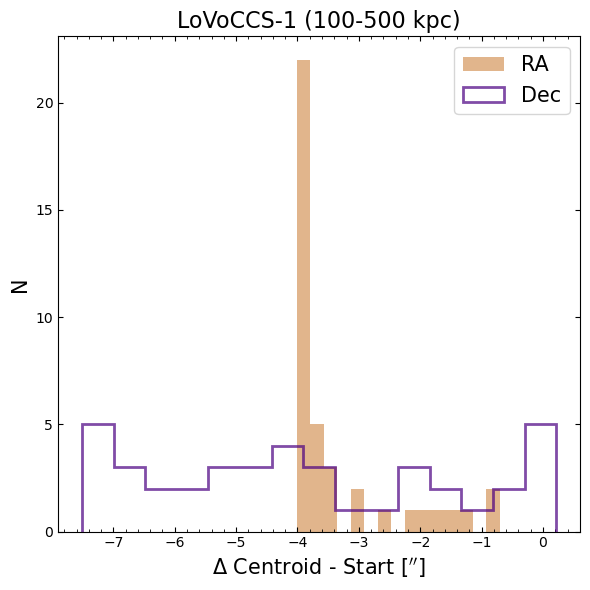

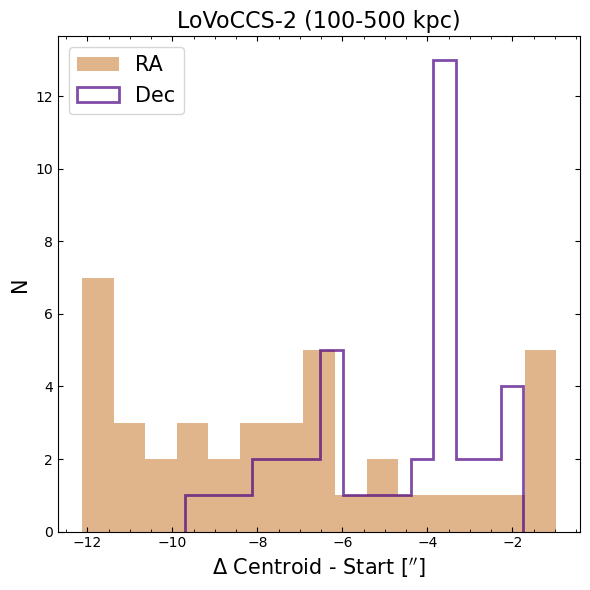

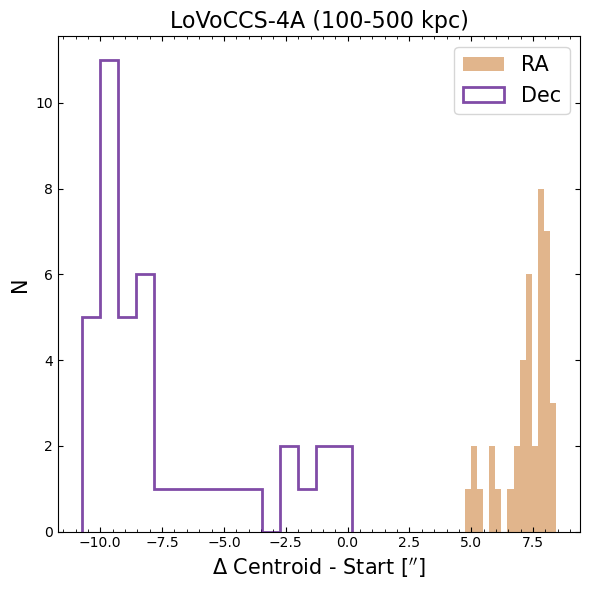

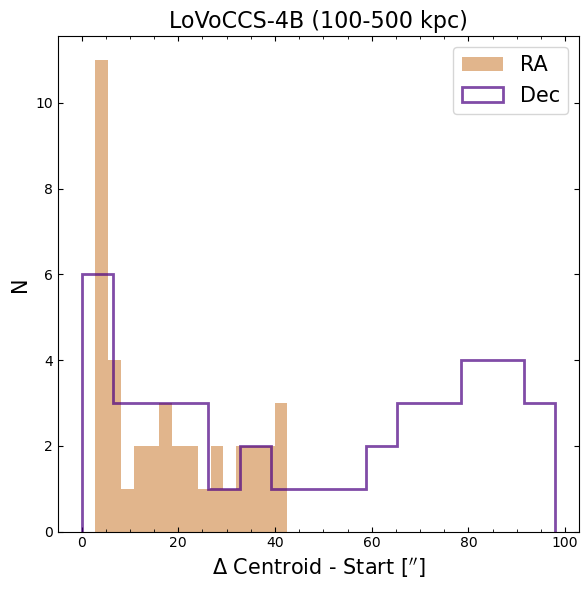

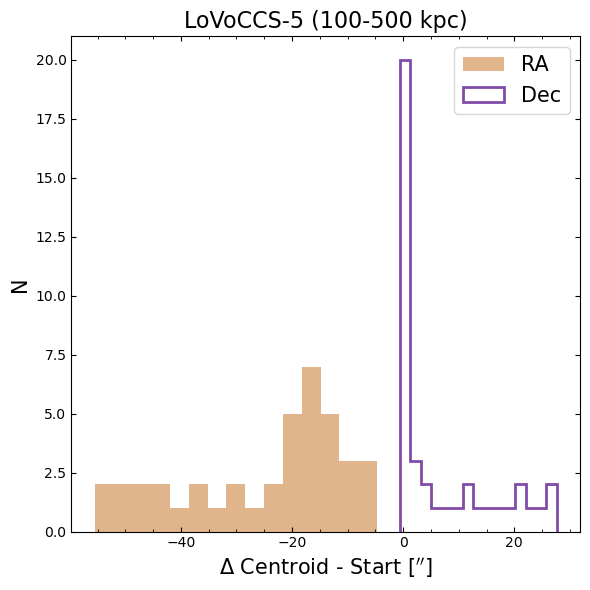

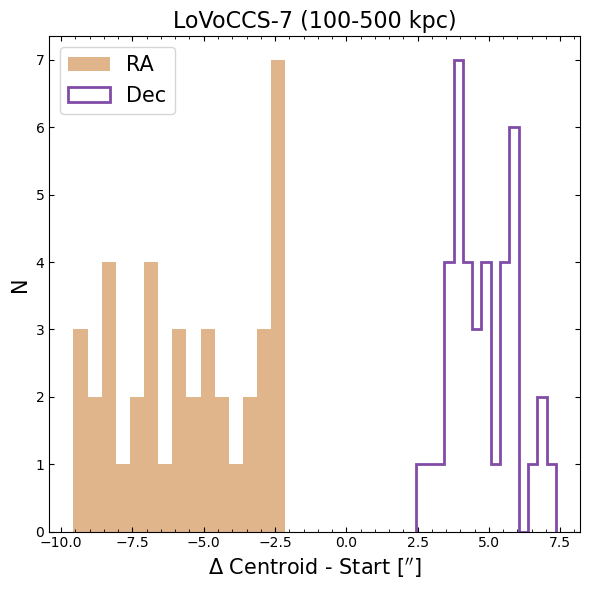

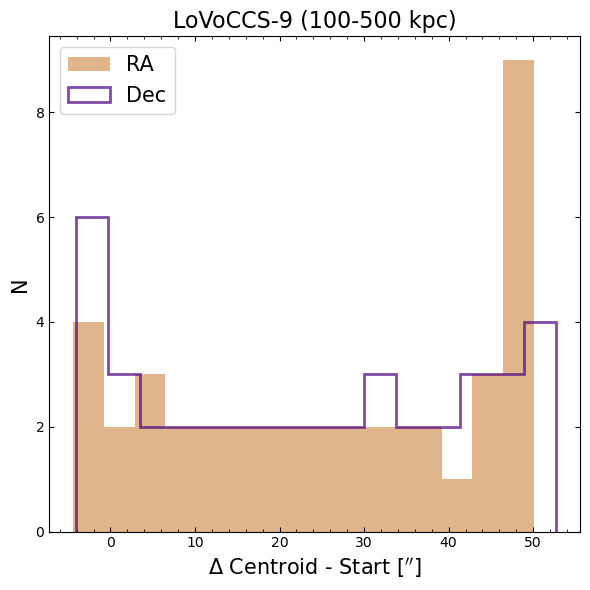

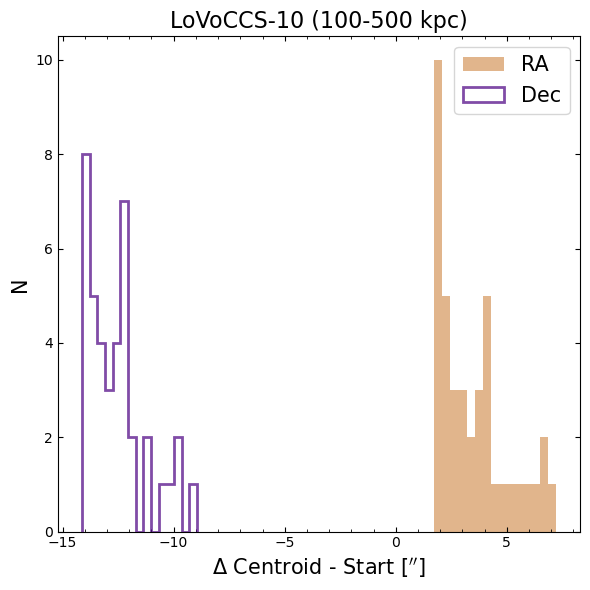

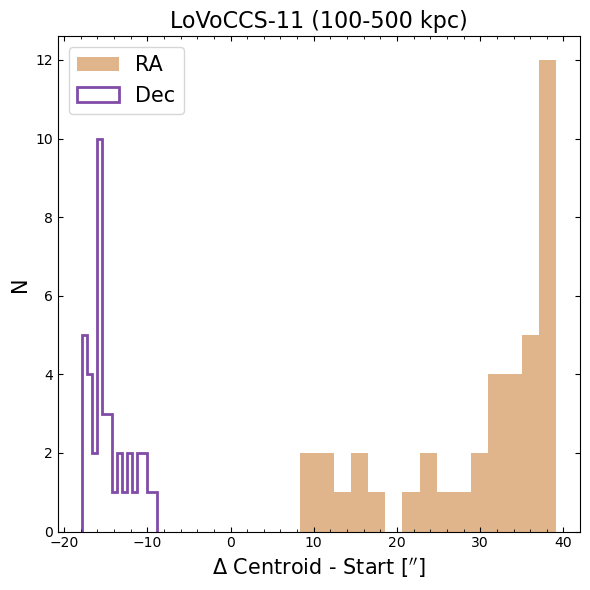

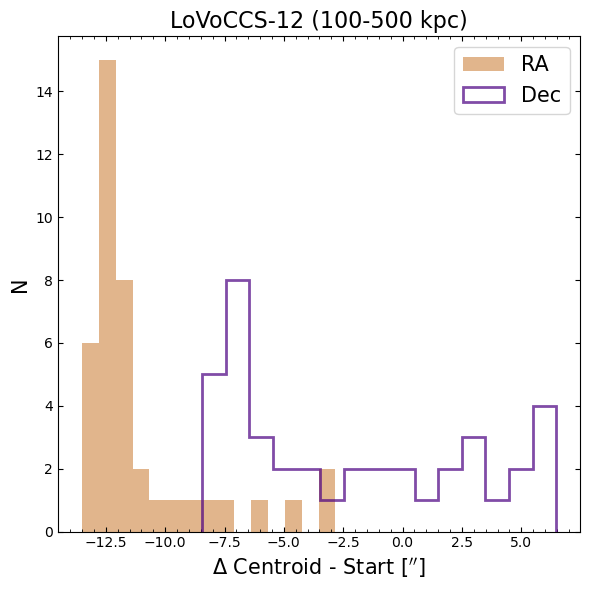

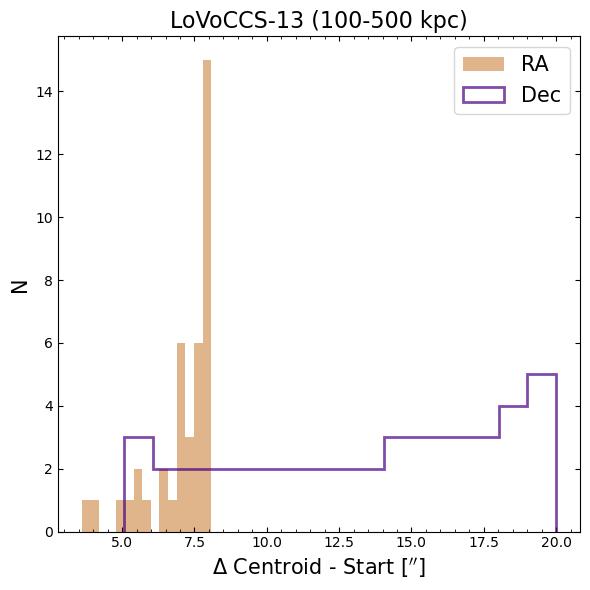

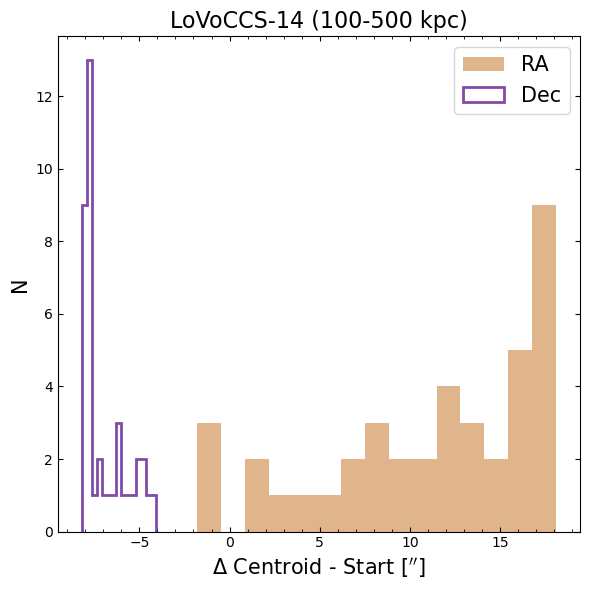

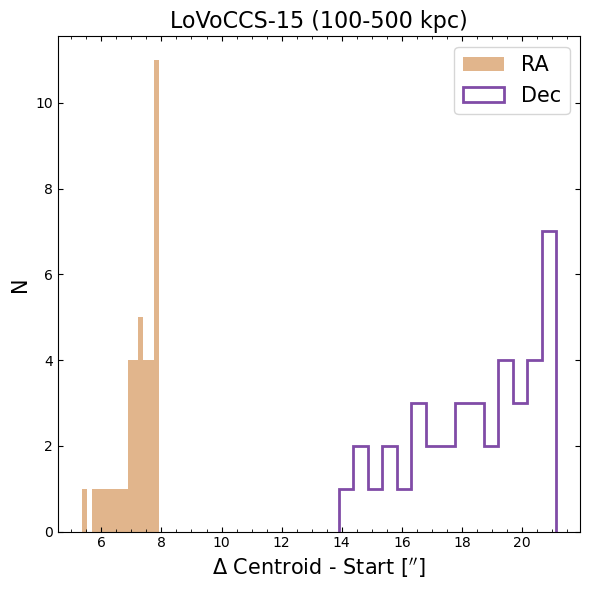

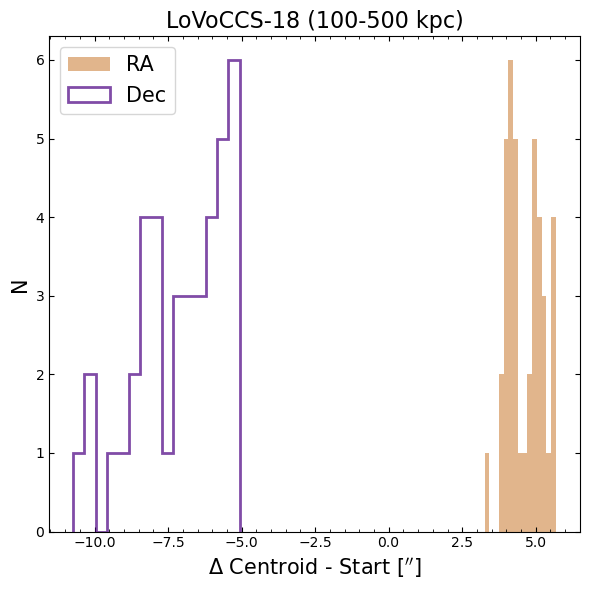

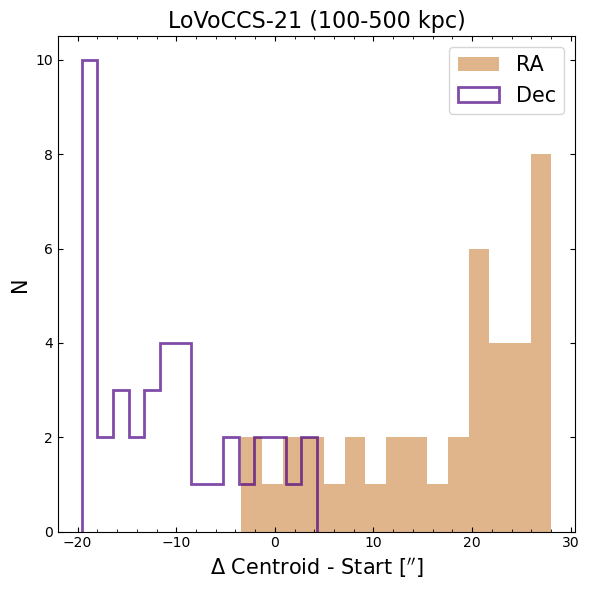

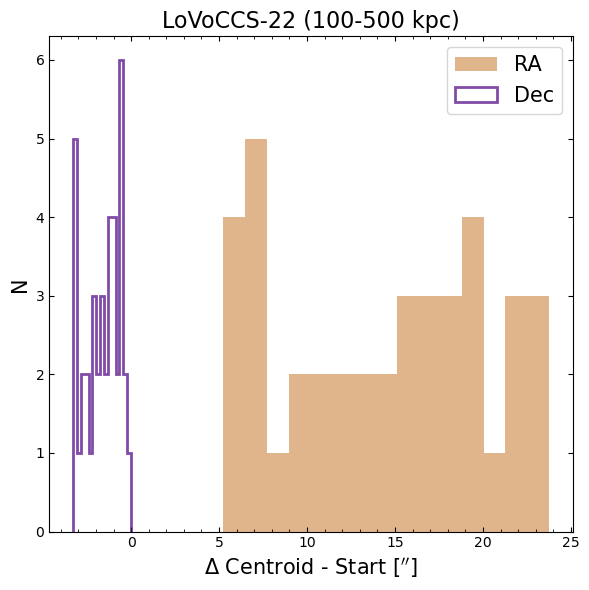

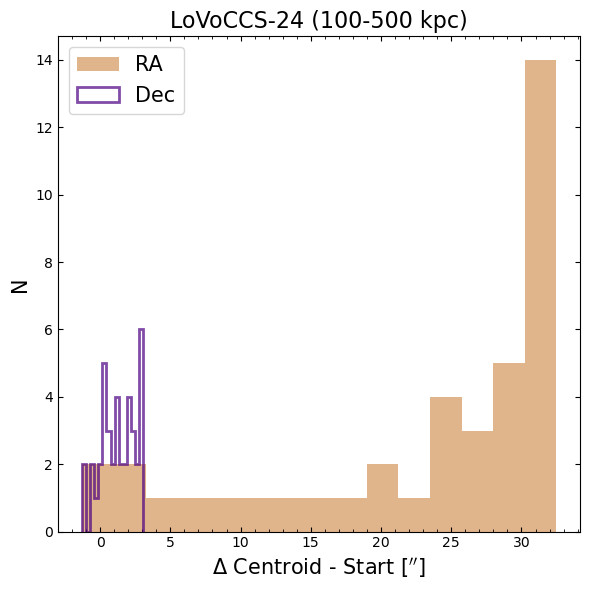

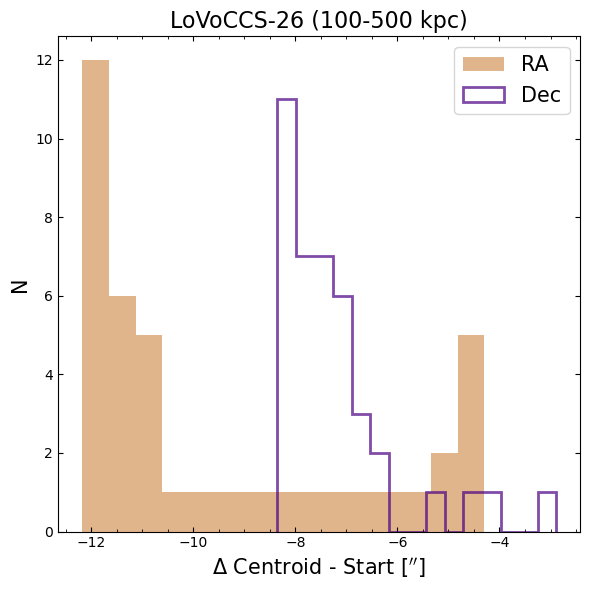

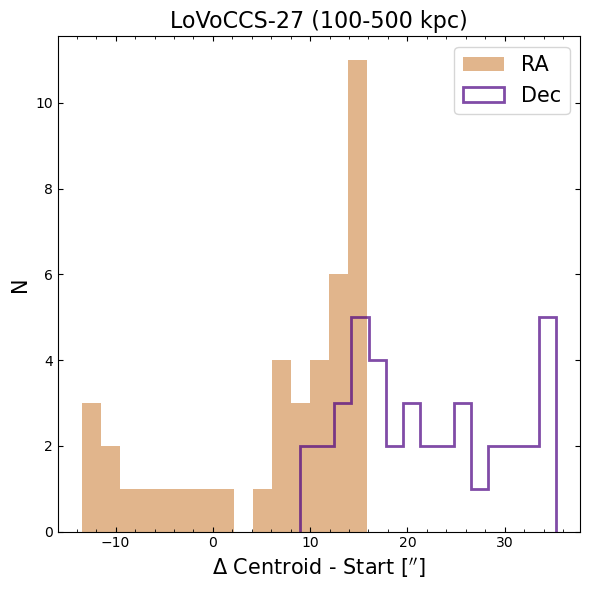

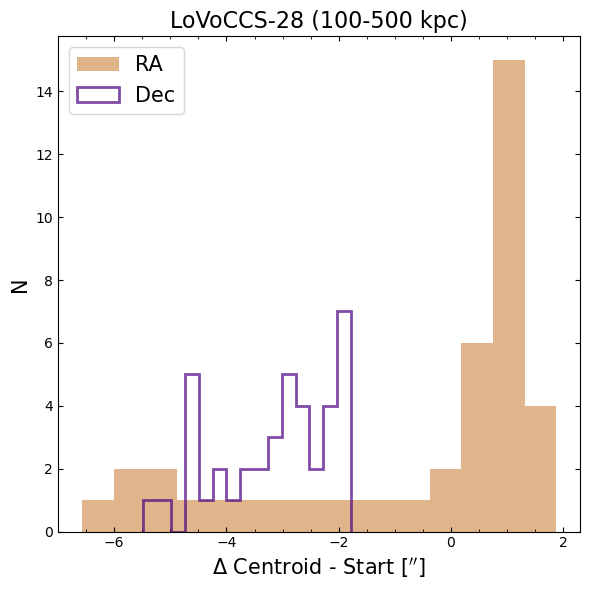

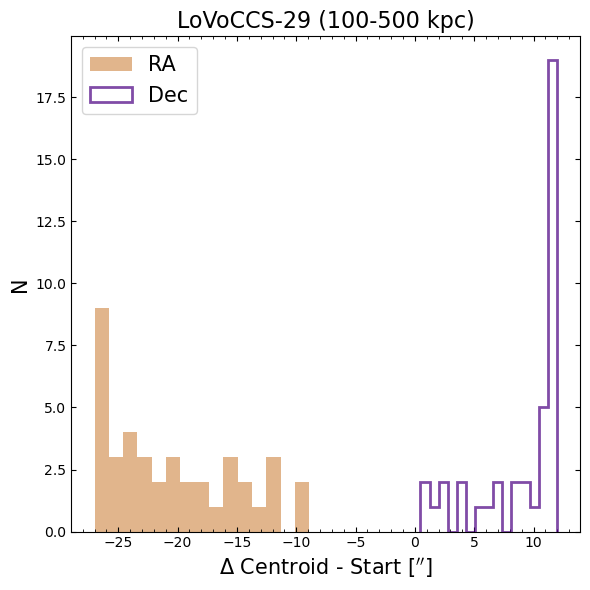

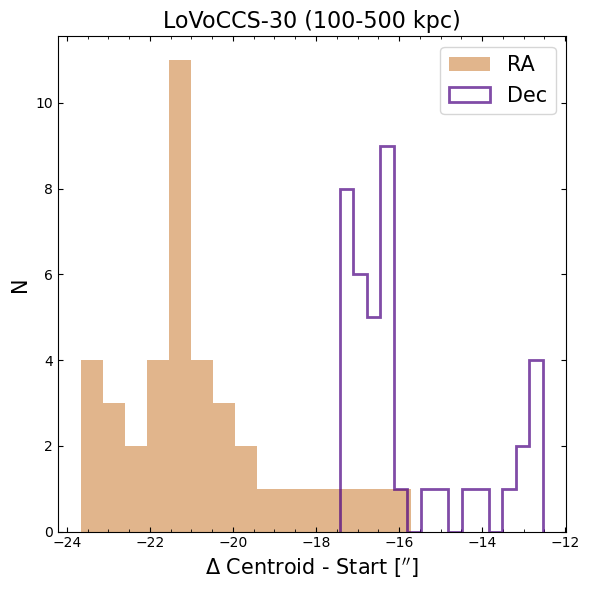

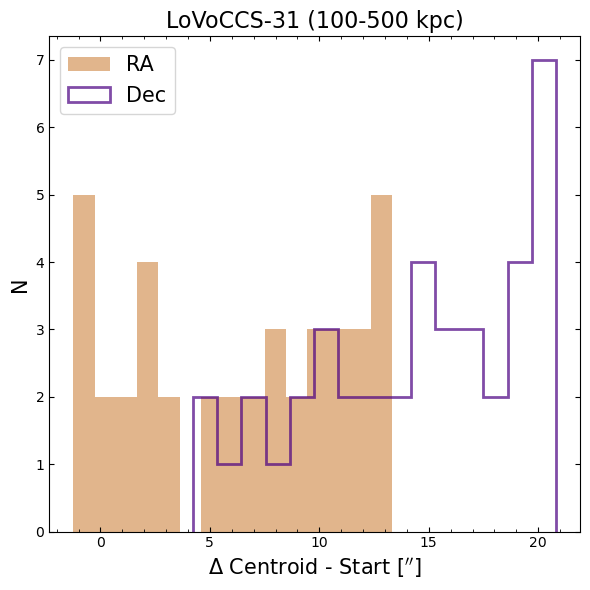

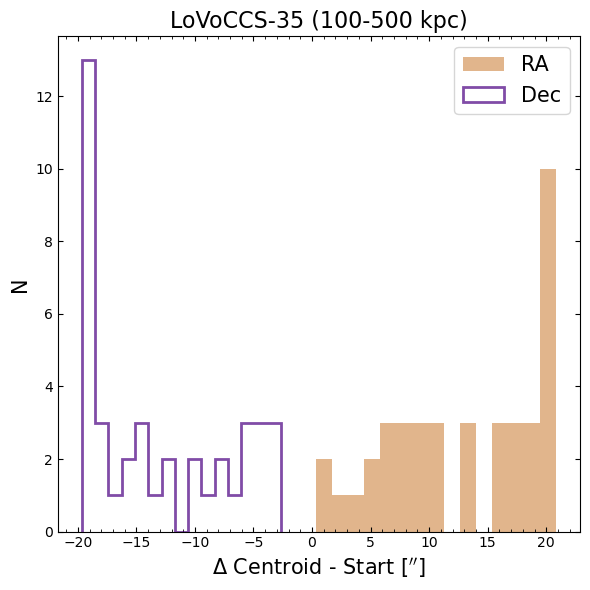

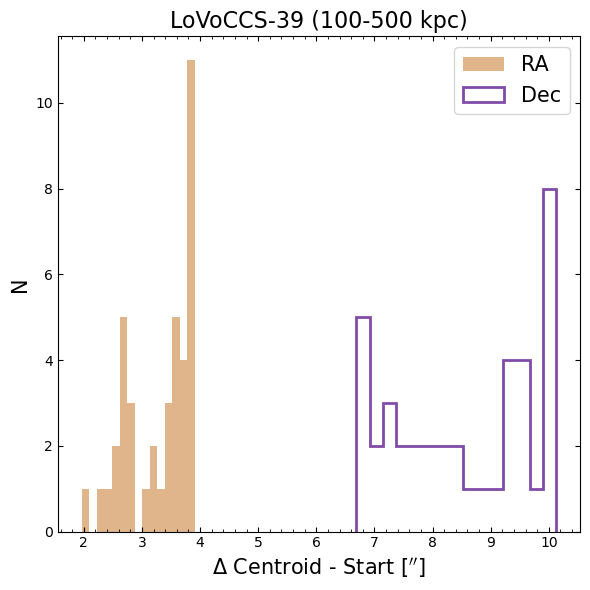

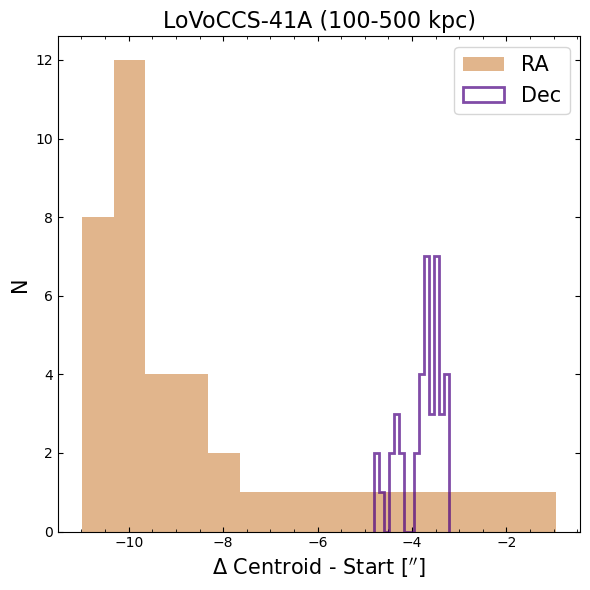

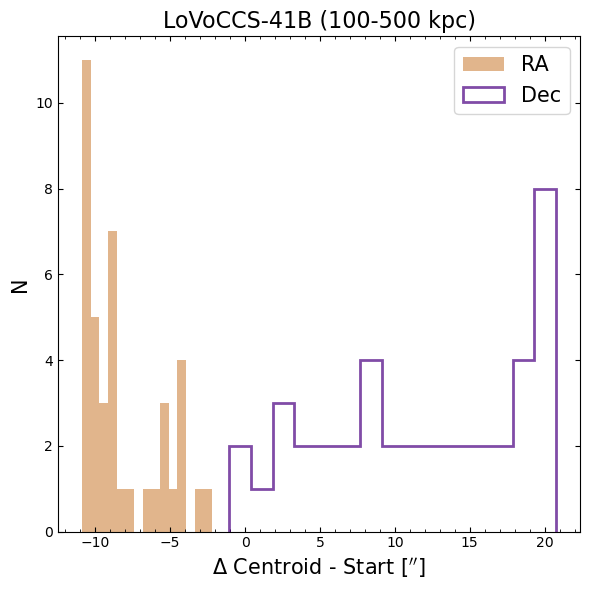

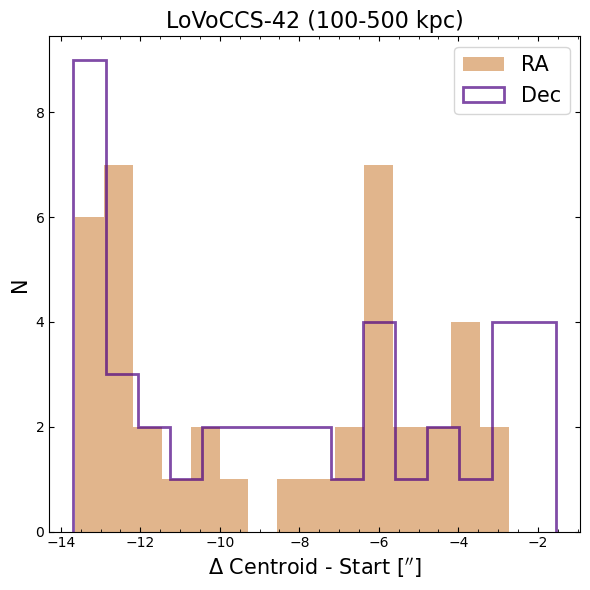

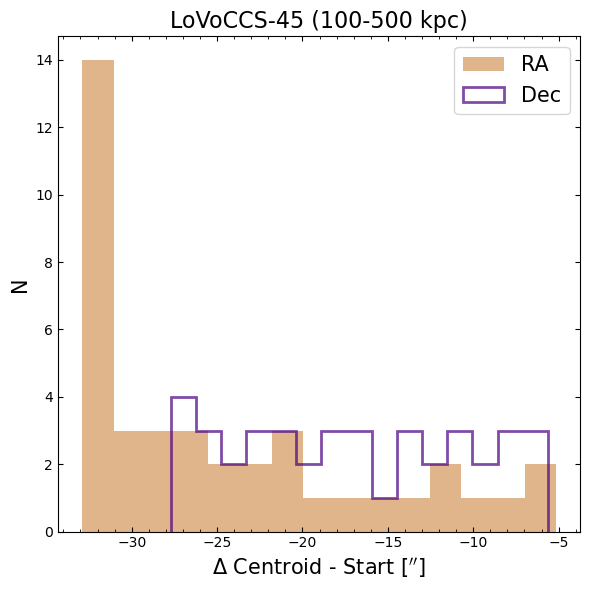

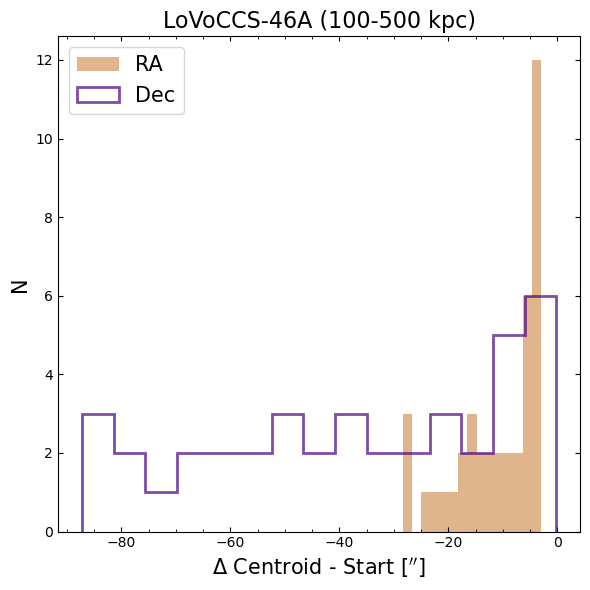

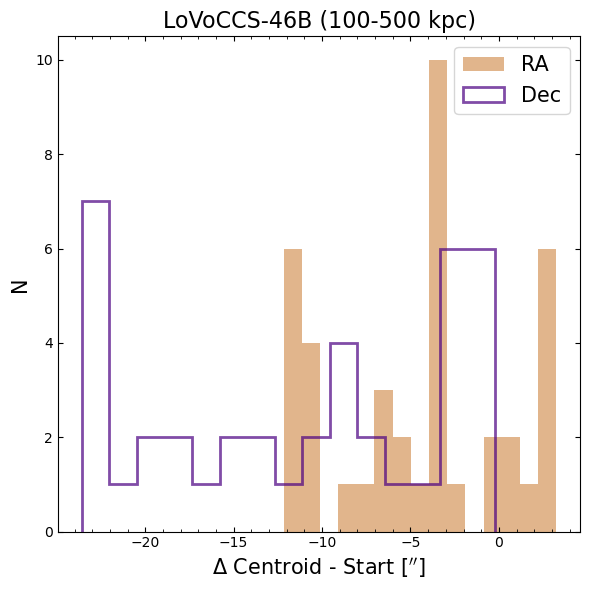

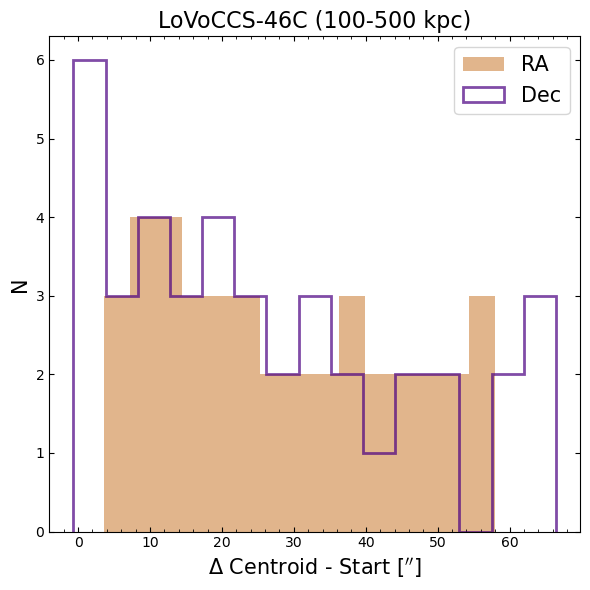

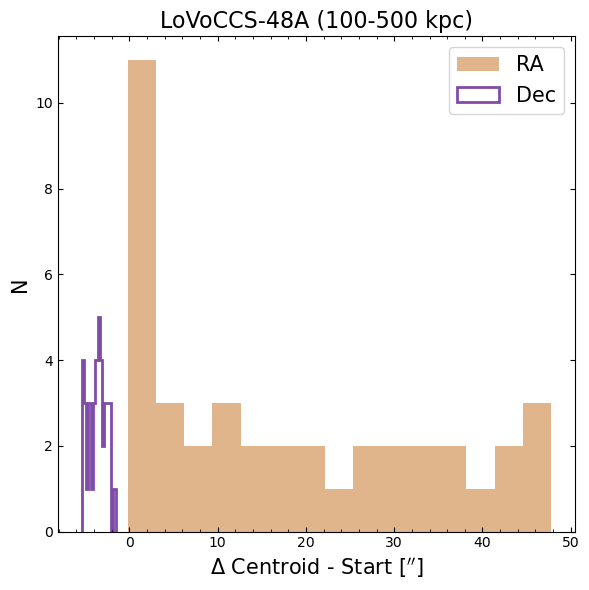

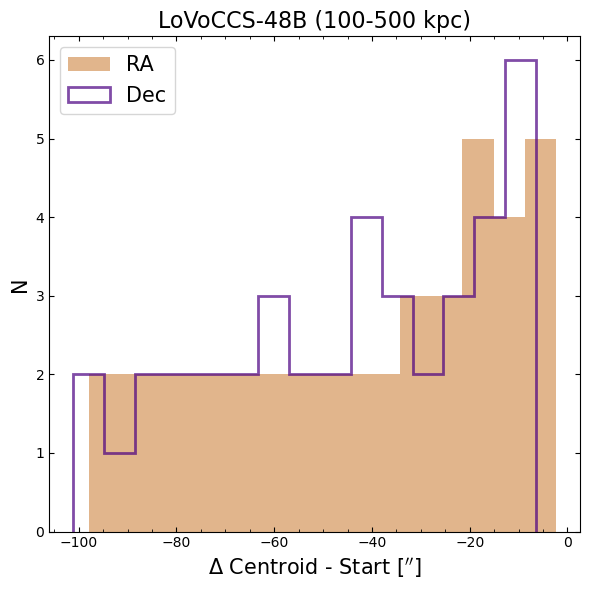

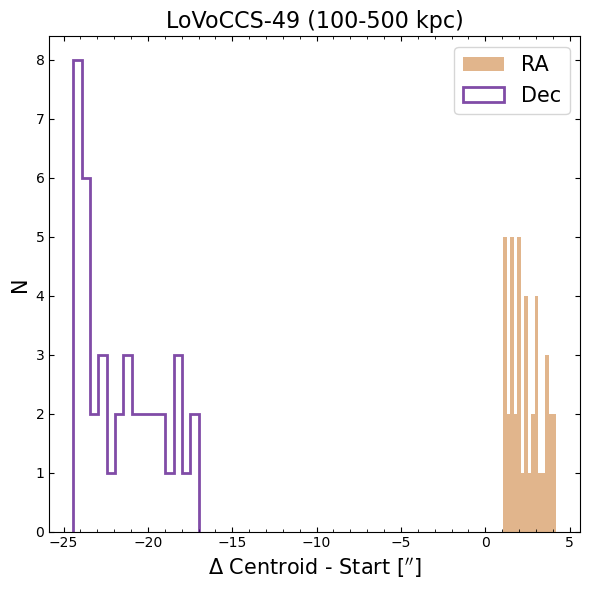

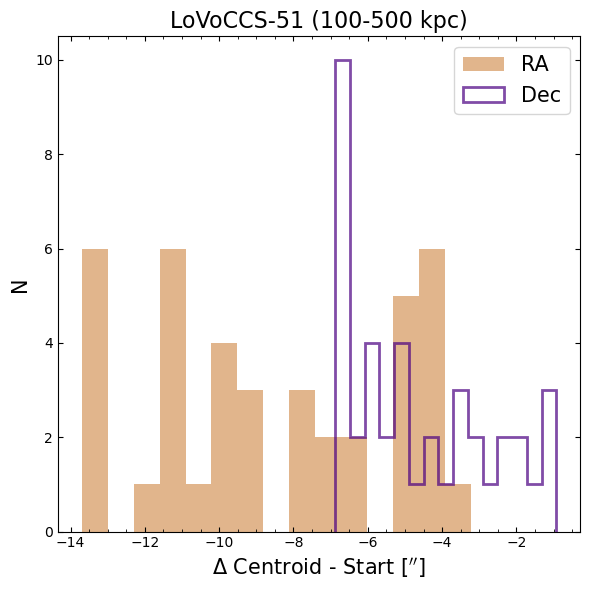

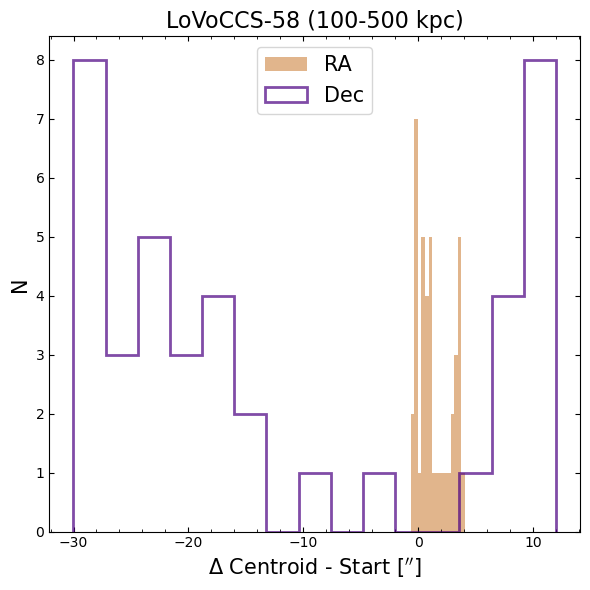

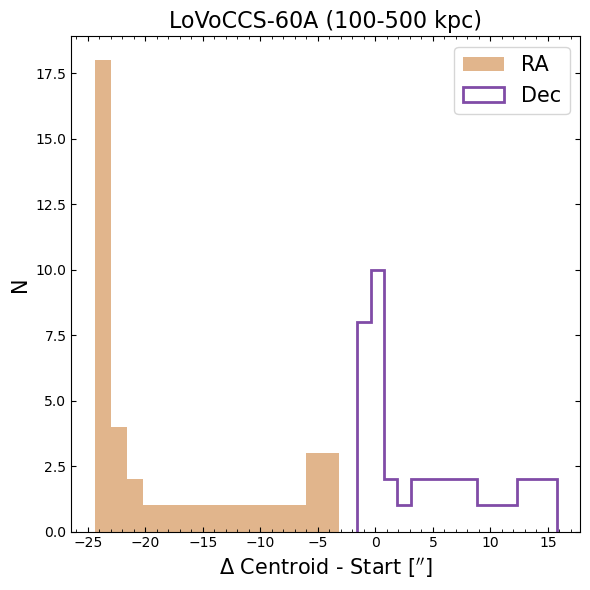

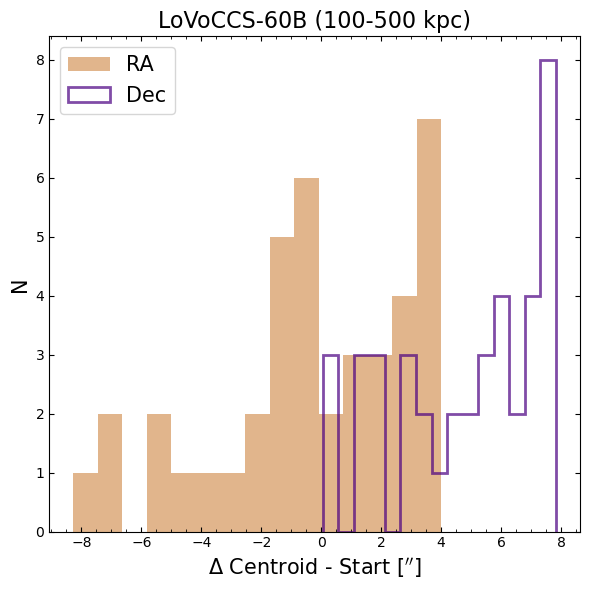

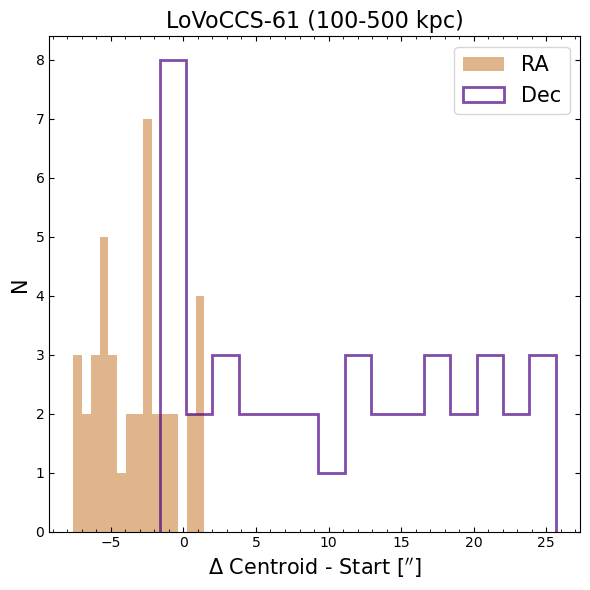

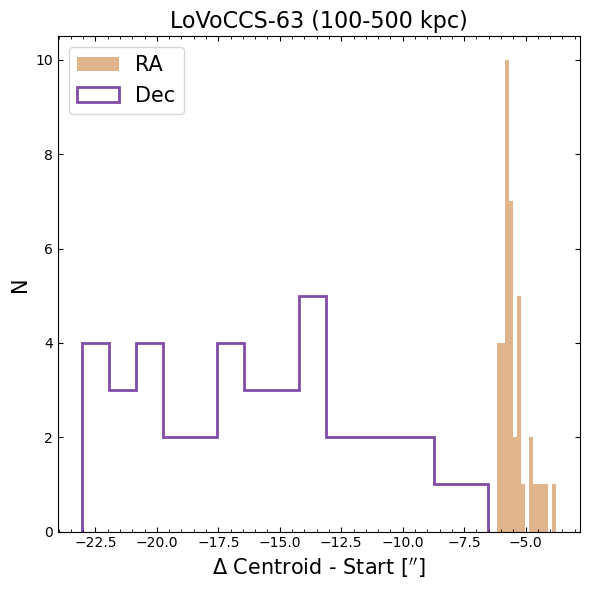

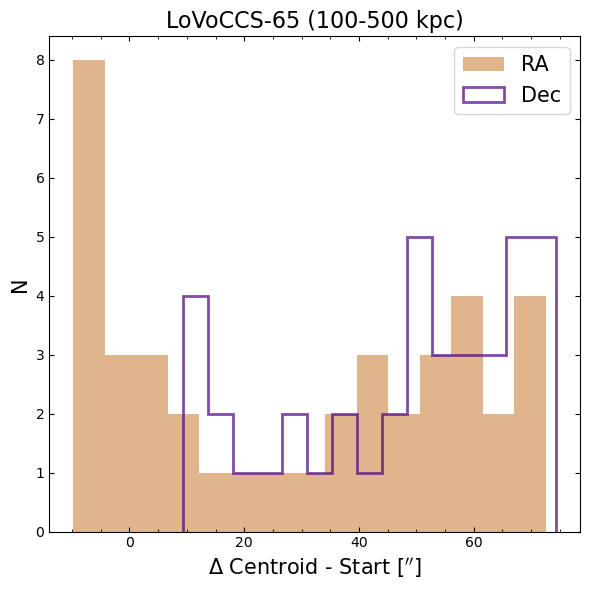

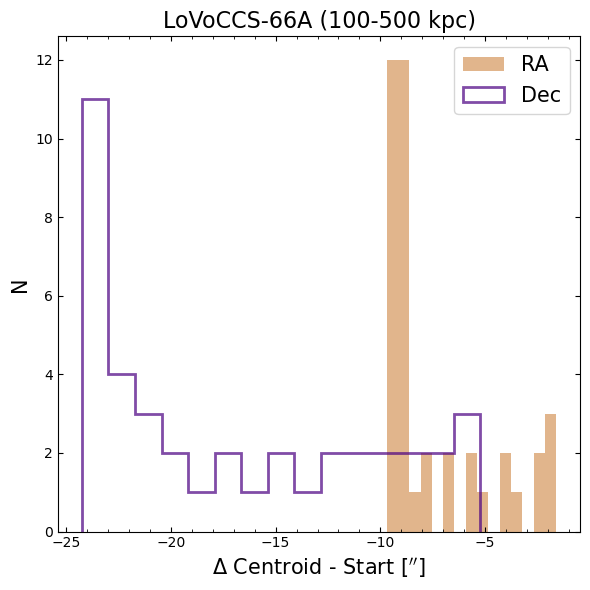

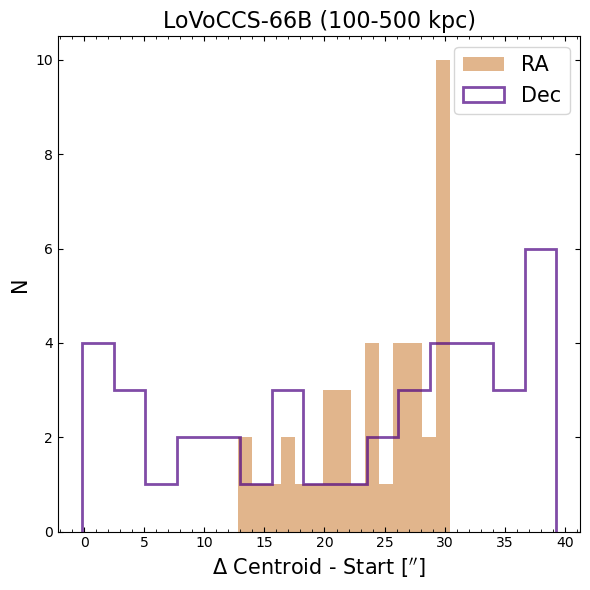

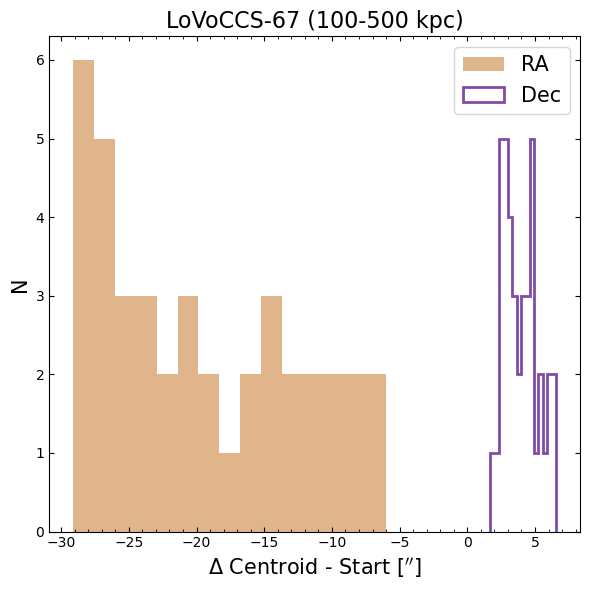

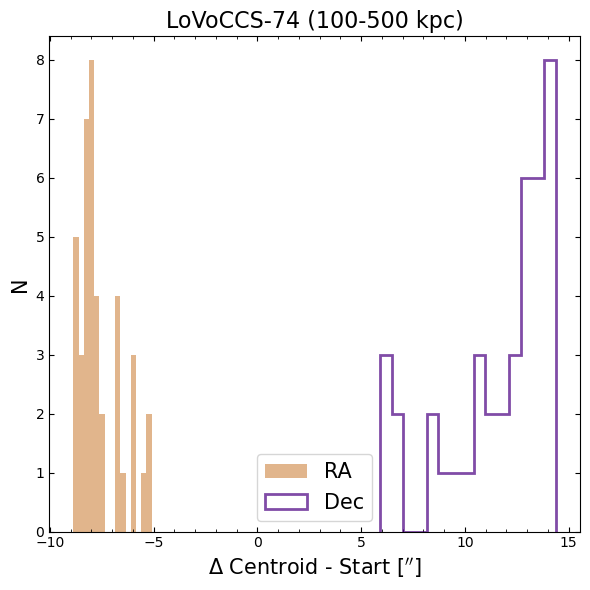

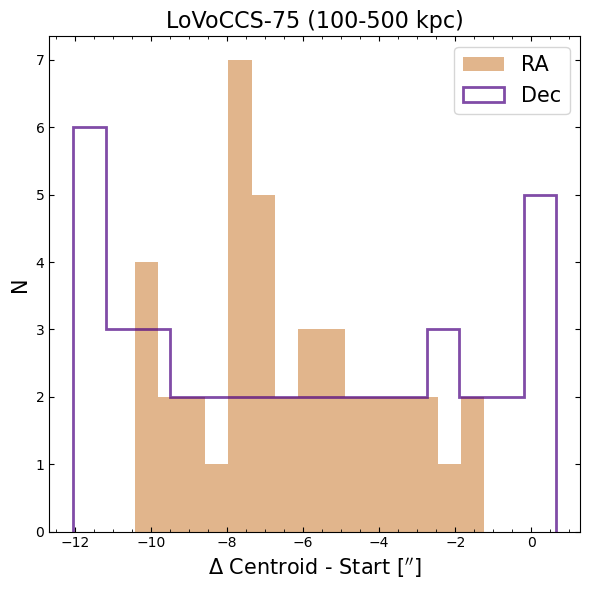

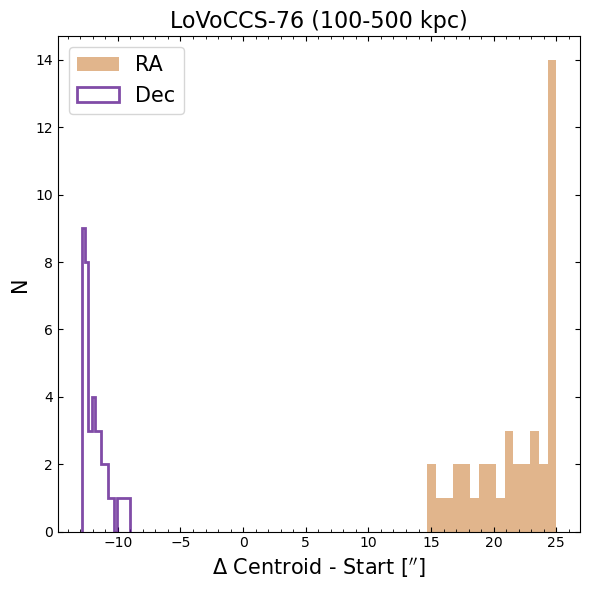

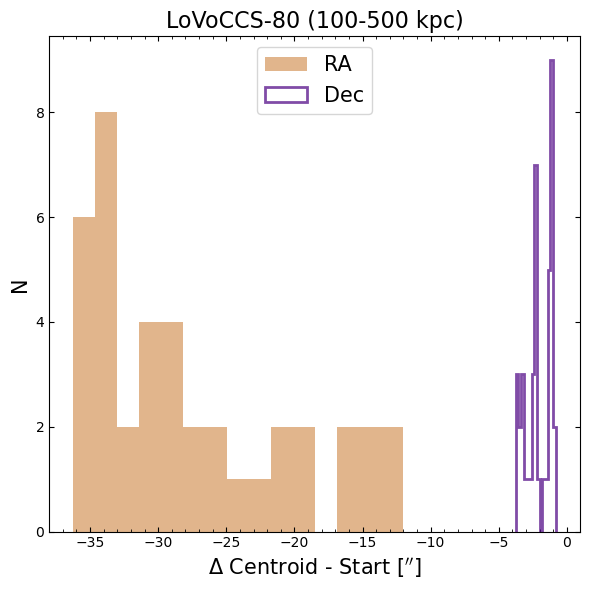

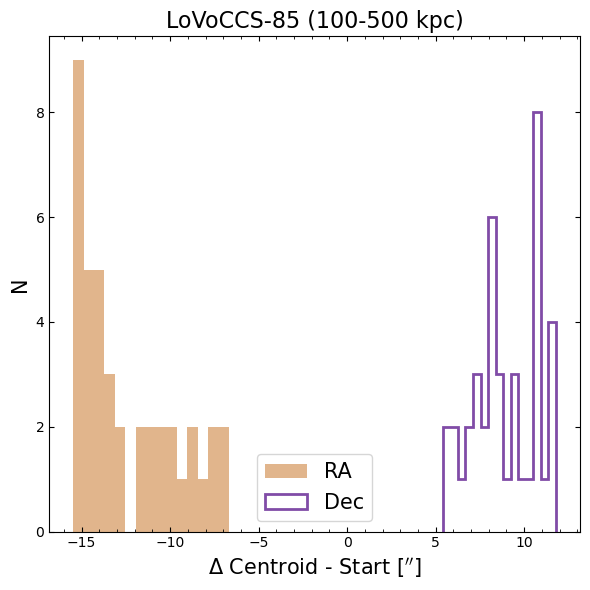

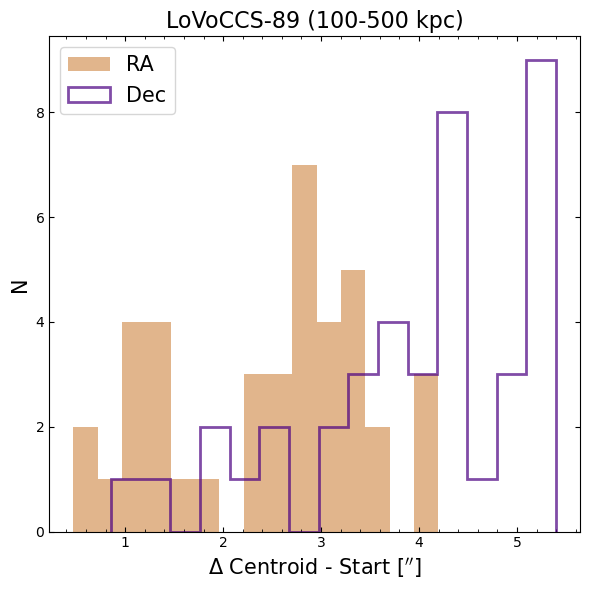

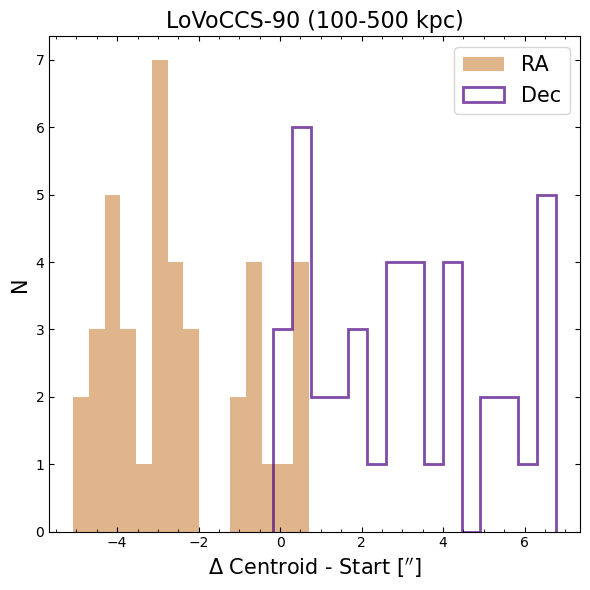

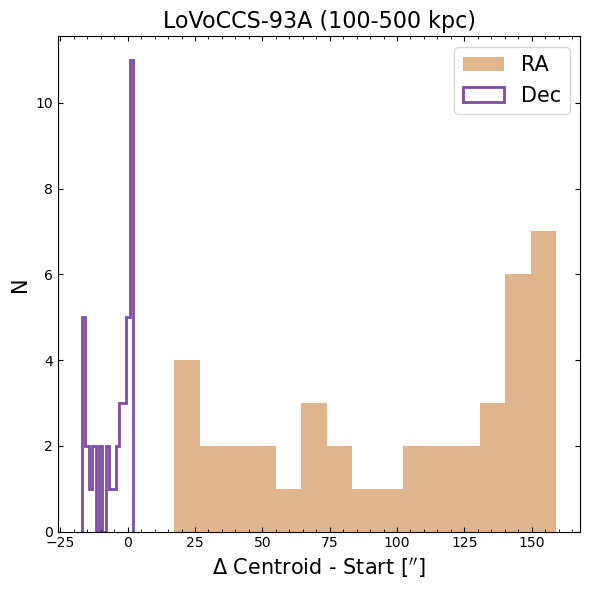

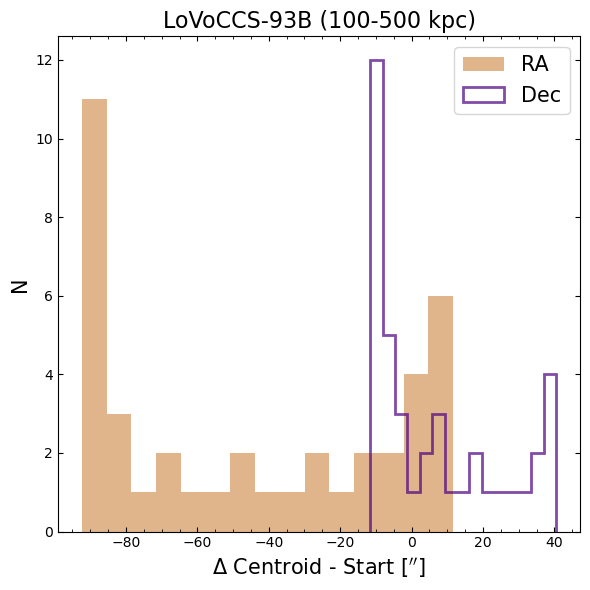

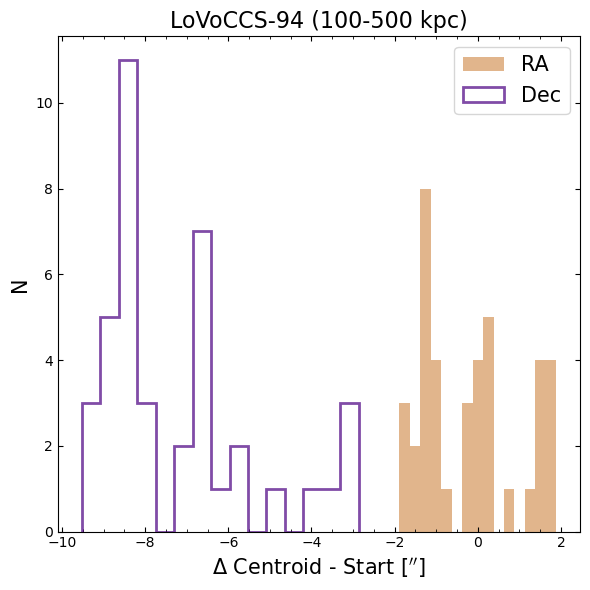

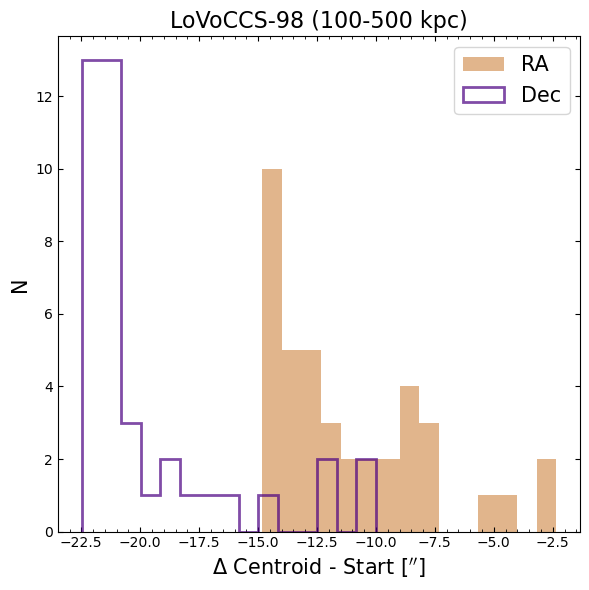

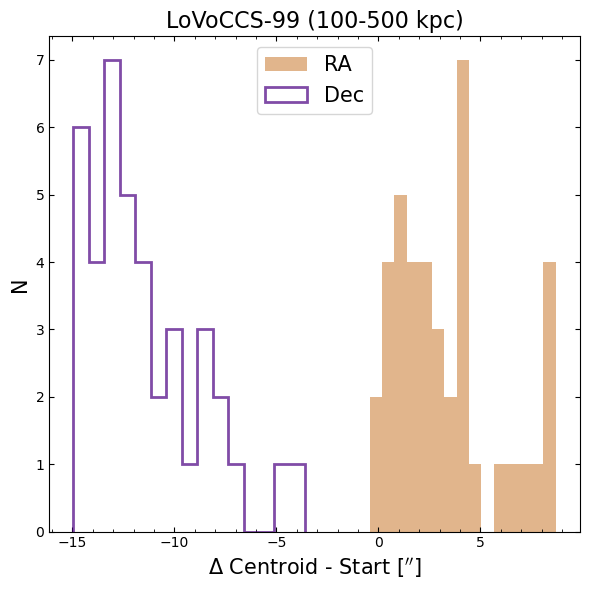

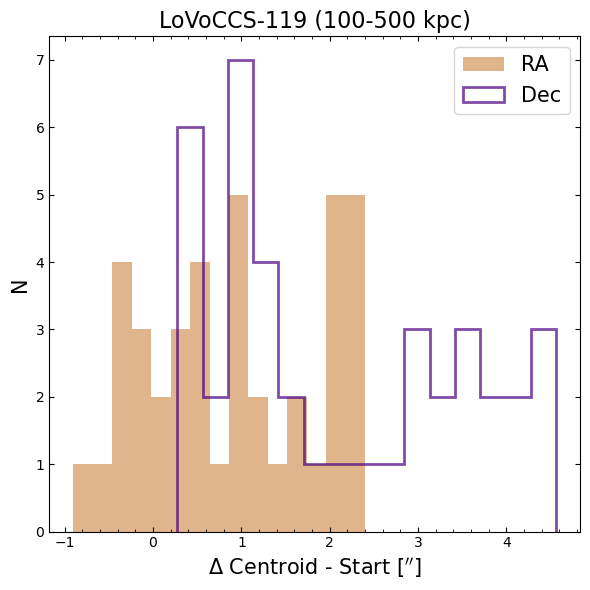

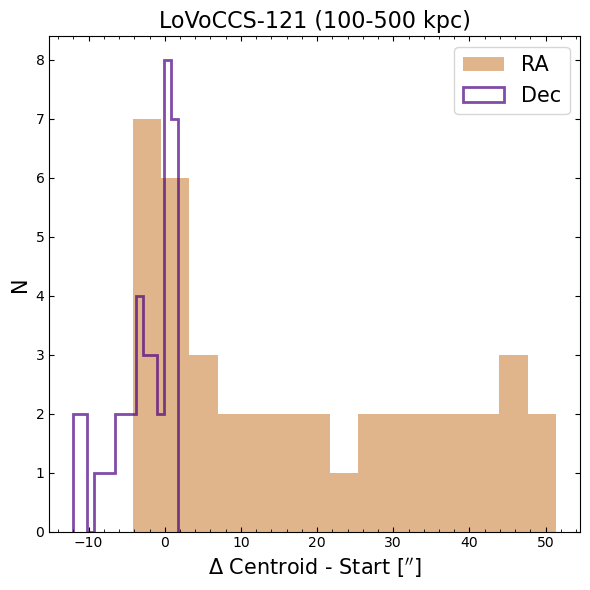

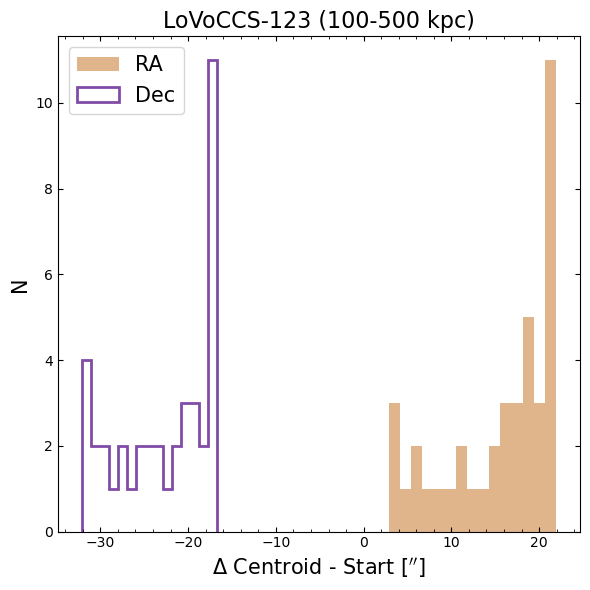

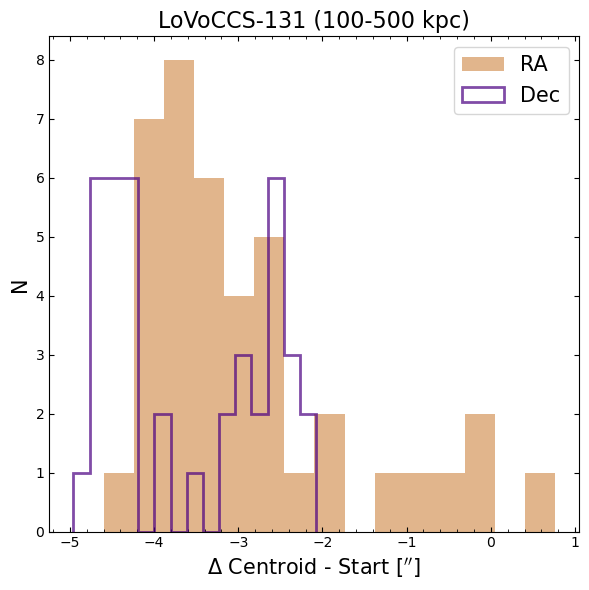

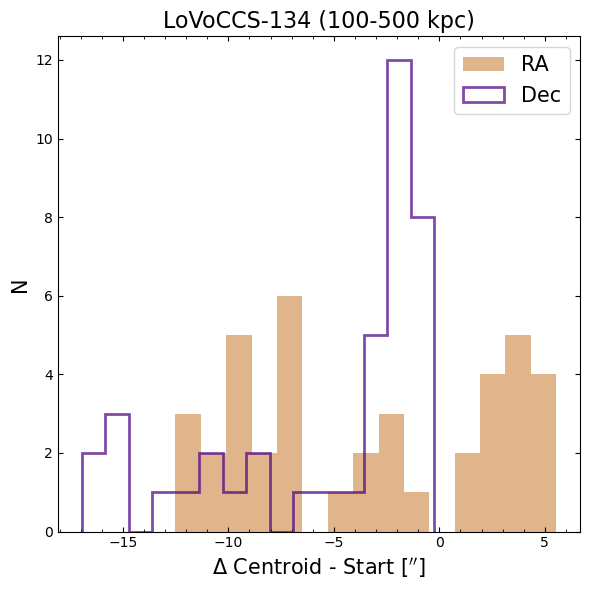

In [10]:
back_ap_inn = Quantity(800, 'kpc')
back_ap_out = Quantity(1000, 'kpc')

cents = {}
for src in srcs:
    cents[src.name] = []
    ap_rng = Quantity(np.linspace(100, 500, 40), 'kpc')
    for ap in ap_rng:
        cur_cen, cur_ang, cur_x_scale, cur_y_scale, cur_cen_dist, cur_pa_dist, cur_x_scale_dist, \
            cur_y_scale_dist = centroid_shape_estimate(src, ap, num_samp=0, back_inn_rad=back_ap_inn, 
                                                       back_out_rad=back_ap_out)
        cents[src.name].append(cur_cen)
    
    rel_cents = Quantity(cents[src.name])
    plt.figure(figsize=(6, 6))
    
    ax = plt.gca()
    ax.minorticks_on()
    ax.tick_params(which='both', direction='in', top=True, right=True)
    ax.tick_params(which='minor', left=False, right=False)

    ax.hist((rel_cents[:, 0].value - src.ra_dec[0].value)*3600, bins=15, histtype='stepfilled', color='peru', 
            lw=2, alpha=0.6, label="RA")
    ax.hist((rel_cents[:, 1].value - src.ra_dec[1].value)*3600, bins=15, color='indigo', histtype='step', 
            alpha=0.7, label="Dec", lw=2)
    
    plt.title(src.name + " ({l}-{u} kpc)".format(l=ap_rng[0].value.astype(int), 
                                                 u=ap_rng[-1].value.astype(int)), fontsize=16)
    plt.ylabel("N", fontsize=15)
    plt.xlabel(r"$\Delta$ Centroid - Start [$^{\prime\prime}$]", fontsize=15)
    plt.legend(loc='best', fontsize=15)
    plt.tight_layout()
    
    file_name = "{n}_xmm_centroid_{l}-{u}kpc_{b}bins_dist.pdf".format(n=src.name, l=ap_rng[0].value.astype(int), 
                                                                      u=ap_rng[-1].value.astype(int), 
                                                                      b=len(ap_rng))
    plt.savefig(multi_ap_dist_path + file_name)

    plt.show()
    plt.close('all')

## Common morphology metrics

In this section, we measure some common, and simple, metrics that describe the morphology of the galaxy clusters in our sample.

### Measuring standard centroid shift ($w$)

First of all, we use our centroid-measuring capability to define the 'centroid shift' of each clusters. Centroid shift is defined as, 

$w = [\dfrac{1}{n-1} \Sigma(\Delta_{i} - \langle\Delta\rangle)^{2}]^{0.5}\dfrac{1}{R_{ap}}$,

where we use $n=20$ and $R_{ap}=500$ kpc, which are commonly used values. This shift measurement helps to summarise how disturbed the clusters are, with higher values indicating larger deviations of the centroid from the peak.

In [11]:
frac_ap = np.linspace(0.05, 1, 20)
seq_aps = frac_ap*Quantity(500, 'kpc')
seq_aps

<Quantity [ 25.,  50.,  75., 100., 125., 150., 175., 200., 225., 250.,
           275., 300., 325., 350., 375., 400., 425., 450., 475., 500.] kpc>

In [13]:
# This defines the number of times the count-rate map is resampled to calculate the statistical uncertainties
resamp = 100
# The confidence level for the extracted uncertainties
conf_level = 90

back_ap_inn = Quantity(800, 'kpc')
back_ap_out = Quantity(1000, 'kpc')

cen_shifts = []
cen_shift_dists = []
stand_cents = {}
stand_cent_dists = {}

for src in srcs:
    stand_cents[src.name] = []
    stand_cent_dists[src.name] = []
    
    try:
        rel_peak_row = peaks[peaks['name'] == src.name].iloc[0]
        rel_peak = Quantity(rel_peak_row[['peak_ra', 'peak_dec']], 'deg')
    except:
        cen_shifts.append([np.NaN, np.NaN, np.NaN])
        continue
    
    shift_cens, shift_angs, shift_xs, shift_ys, shift_cen_dists, shift_pa_dists, \
        shift_cur_x_dists, shift_cur_y_dists = centroid_shape_estimate(src, seq_aps, num_samp=resamp, 
                                                                       back_inn_rad=back_ap_inn, 
                                                                       back_out_rad=back_ap_out, 
                                                                       cent_coord=rel_peak)
            
    rel_cents = Quantity(shift_cens)
    stand_cents[src.name].append(rel_cents)
    
    ang_dists = haversine(rel_peak[0], rel_peak[1], rel_cents[:, 0], rel_cents[:, 1])
    prop_dists = src.convert_radius(ang_dists, 'kpc')
    mean_dist = prop_dists.mean()

    # cen_shift = np.sqrt((1/(len(frac_ap)-1))*((prop_dists - mean_dist)**2).sum()) * (1/seq_aps[-1])
    
    # This uses the N realisations of the centroid that we calculated to estimate the uncertainty on
    #  the centroid shift
    cen_dists = Quantity(shift_cen_dists)
    stand_cent_dists[src.name].append(cen_dists)
    prop_cent_diff_dist = src.convert_radius(haversine(rel_peak[0], rel_peak[1], cen_dists[:, :, 0], 
                                                       cen_dists[:, :, 1]), 'kpc')
    expec_diff = prop_cent_diff_dist.mean(axis=0)
    cen_shift_dist = (np.sqrt((1/(len(frac_ap)-1))*((prop_cent_diff_dist - expec_diff)**2).sum(axis=0)) * 
                      (1/seq_aps[-1]))
    
    cen_shift_median = np.percentile(cen_shift_dist, 50, axis=0)
    cen_shift_pl = np.percentile(cen_shift_dist, 50 + (conf_level/2), axis=0) - cen_shift_median
    cen_shift_mi = cen_shift_median - np.percentile(cen_shift_dist, 50 - (conf_level/2), axis=0)
    
    # Append the calculated values and the uncertainties, as well as the whole distribution
    cen_shifts.append([cen_shift_median, cen_shift_mi, cen_shift_pl])
    cen_shift_dists.append(cen_shift_dist)
    
cen_shifts = np.array(cen_shifts)
cen_shift_dist = np.array(cen_shift_dist)

### Measuring concentration parameter ($c$)

We also measure the 'concentration parameter', which is even simpler than the centroid shift (but highly useful) - it is just the ratio of flux within a 100 kpc aperture centered on the core of the cluster, and the flux within a 500 kpc aperture centered on the same spot:

$c = \dfrac{F_{\leq100\rm{kpc}}}{F_{\leq500\rm{kpc}}}$

Interpreting it is quite easy, as it should be fairly obvious that cool-core clusters (with denser, brighter, cores) will have higher concentration values than disturbed clusters.

<!-- $c = \dfrac{\sum\limits_{x,y}^{R\leq100\rm{kpc}}}{\sum\limits_{x,y}^{R\leq500\rm{kpc}}}$ -->

In [15]:
# This defines the number of times the count-rate map is resampled to calculate the statistical uncertainties
resamp = 100
# The confidence level for the extracted uncertainties
conf_level = 90

back_ap_inn = Quantity(800, 'kpc')
back_ap_out = Quantity(1000, 'kpc')

concs = []
for src in srcs:
    try:
        # TODO DECIDE ON WHETHER TO USE PEAK OR CENTROID
        rel_peak_row = peaks[peaks['name'] == src.name].iloc[0]
        rel_peak = Quantity(rel_peak_row[['peak_ra', 'peak_dec']], 'deg')

        cur_rt = src.get_combined_ratemaps()

        back_mask = src.get_custom_mask(back_ap_out, back_ap_inn, remove_interlopers=True, 
                                        central_coord=rel_peak)    

        data_cp = cur_rt.data.copy()

        back_area = (back_mask * cur_rt.sensor_mask).sum()
        back_rt = np.sum(data_cp*back_mask)/back_area
        data_cp = data_cp - back_rt
        data_cp[data_cp < 0] = 0
        
        cont_mask = src.get_interloper_mask()
        ap100kpc_mask = src.get_custom_mask(Quantity(100, 'kpc'), remove_interlopers=True, 
                                            central_coord=rel_peak)
        ap500kpc_mask = src.get_custom_mask(Quantity(500, 'kpc'), remove_interlopers=True, 
                                            central_coord=rel_peak)

        conc = (data_cp*ap100kpc_mask).sum() / (data_cp*ap500kpc_mask).sum()
        
        rng = np.random.default_rng()
        resamp_data = np.repeat((data_cp*cont_mask)[:, :, np.newaxis], resamp, axis=2)
        resamp_data = rng.poisson(resamp_data*cur_rt.expmap.data[..., None])/cur_rt.expmap.data[..., None]
        resamp_data[np.isnan(resamp_data)] = 0
        
        conc_dist = (resamp_data*ap100kpc_mask[..., None]).sum(axis=(0, 1)) / \
            (resamp_data*ap500kpc_mask[..., None]).sum(axis=(0, 1))
        
        conc_median = np.percentile(conc_dist, 50, axis=0)
        conc_pl = np.percentile(conc_dist, 50 + (conf_level/2), axis=0) - conc_median
        conc_mi = conc_median - np.percentile(conc_dist, 50 - (conf_level/2), axis=0)
        
        concs.append([conc_median, conc_mi, conc_pl])        
        
    except IndexError:
        concs.append([np.NaN, np.NaN, np.NaN])

concs = np.array(concs)

### Saving morphological parameters

Here we construct a save file containing the measured morphological parameters:

In [16]:
out_data = np.concatenate([srcs.names[..., None], cen_shifts.round(4), concs.round(4)], 
                          axis=1)
out_cols = ['name', 'cen_shift', 'cen_shift-', 'cen_shift+', 'concentration', 
            'concentration-', 'concentration+']
out_morph_df = pd.DataFrame(out_data, columns=out_cols)

file_name = "xmm_centshift_concentration.csv".format(n=src.name)
out_morph_df.to_csv(coords_morph_out_path + file_name, index=False)
out_morph_df

name cen_shift cen_shift- cen_shift+ concentration concentration-  \
0     LoVoCCS-1    0.0057     0.0001     0.0001        0.4412         0.0004   
1     LoVoCCS-2    0.0659     0.0005     0.0006        0.1638         0.0015   
2    LoVoCCS-4A       nan        nan        nan           nan            nan   
3    LoVoCCS-4B       nan        nan        nan           nan            nan   
4     LoVoCCS-5    0.0815     0.0005     0.0003        0.1245         0.0005   
..          ...       ...        ...        ...           ...            ...   
57  LoVoCCS-119    0.0048     0.0004     0.0003        0.5271         0.0017   
58  LoVoCCS-121    0.0811     0.0009      0.001        0.1871         0.0022   
59  LoVoCCS-123    0.0185      0.001     0.0007        0.5669         0.0039   
60  LoVoCCS-131    0.0124     0.0016     0.0016         0.193         0.0054   
61  LoVoCCS-134    0.0272     0.0037     0.0044        0.0962         0.0032   

   concentration+  
0          0.0005  
1          0.0018  
2             nan  
3             nan  
4          0.0005  
..            ...  
57          0.002  
58         0.0022  
59         0.0044  
60          0.006  
61         0.0024  

[62 rows x 7 columns]

## Concentration parameter vs centroid shift

We plot the concentration parameters and centroid shifts that we have measured for our sample - this is often used to explore how relaxed a sample of galaxy clusters is - we also overplot values proposed by [Cassano et al. (2010)](https://ui.adsabs.harvard.edu/abs/2010A%26A...509A..68C/abstract) to separate relaxed and disturbed clusters (high values of concentration parameter and low values of centroid shift indicate relaxation):

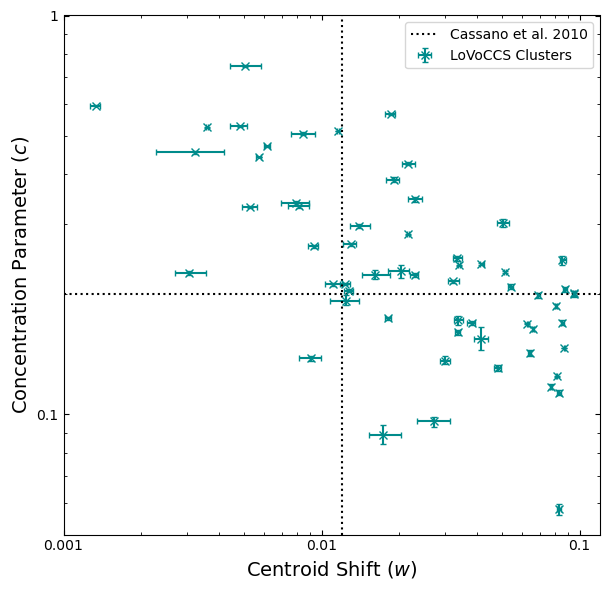

In [17]:
plt.figure(figsize=(6.2, 6))

xlims = [1e-3, 0.12]
ylims = [5e-2, 1]

if (cen_shifts[:, 0] < xlims[0]).any() or (cen_shifts[:, 0] > xlims[1]).any():
    raise ValueError("Adjust the manual centroid shift axis limits.")

if (concs[:, 0] < ylims[0]).any() or (concs[:, 0] > ylims[1]).any():
    raise ValueError("Adjust the manual concentration axis limits.")

plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)

plt.errorbar(cen_shifts[:, 0], concs[:, 0], xerr=cen_shifts[:, 1:].T, yerr=concs[:, 1:].T, fmt='x', 
             color='darkcyan', label='LoVoCCS Clusters', capsize=2) 

plt.axvline(0.012, color='black', linestyle='dotted', label="Cassano et al. 2010")
plt.axhline(0.2, color='black', linestyle='dotted')

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r"Centroid Shift ($w$)", fontsize=14)
plt.ylabel(r"Concentration Parameter ($c$)", fontsize=14)

plt.xlim(xlims)
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda inp, _: '{:g}'.format(inp)))

plt.ylim(ylims)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda inp, _: '{:g}'.format(inp)))

plt.legend(loc='best')
plt.tight_layout()
plt.savefig("../../outputs/figures/positions_and_morphology/concentration_censhift.pdf")
plt.show()

We also make a version of the figure with the points colour-coded to indicate whether we identified 1.4GHz emission from their BCG **<span style="color:red">THIS IS CURRENTLY DISABLED, AS WE'RE SWITCHING TO MAINLY USING THE LOVOCCS-II DEFINITIONS OF BCG AND WE NEED TO VERIFY THEIR VLASS EMISSION</span>**:

In [ ]:
# bcg_icm_morph_join = pd.merge(out_morph_df, bcg_samp, on='LoVoCCS_name')
# # Subsetting
# bcg_icm_morph_join_radem = bcg_icm_morph_join[bcg_icm_morph_join['bcg1_vlass'] == True]
# bcg_icm_morph_join_noradem = bcg_icm_morph_join[bcg_icm_morph_join['bcg1_vlass'] == False]
# bcg_icm_morph_join_novlass = bcg_icm_morph_join[bcg_icm_morph_join['bcg1_vlass'].isnull()]

# plt.figure(figsize=(6.2, 6))

# plt.minorticks_on()
# plt.tick_params(which='both', direction='in', top=True, right=True)

# sub_cen_shifts = bcg_icm_morph_join_radem[['cen_shift', 'cen_shift-', 'cen_shift+']].values.astype(float)
# sub_concs = bcg_icm_morph_join_radem[['concentration', 'concentration-', 'concentration+']].values.astype(float)
# plt.errorbar(sub_cen_shifts[:, 0], sub_concs[:, 0], xerr=sub_cen_shifts[:, 1:].T, yerr=sub_concs[:, 1:].T, 
#              fmt='D', color='goldenrod', label='BCG VLASS 1.4Ghz', capsize=2)

# sub_cen_shifts = bcg_icm_morph_join_noradem[['cen_shift', 'cen_shift-', 'cen_shift+']].values.astype(float)
# sub_concs = bcg_icm_morph_join_noradem[['concentration', 'concentration-', 'concentration+']].values.astype(float)
# plt.errorbar(sub_cen_shifts[:, 0], sub_concs[:, 0], xerr=sub_cen_shifts[:, 1:].T, yerr=sub_concs[:, 1:].T, 
#              fmt='x', color='darkcyan', label='No BCG VLASS 1.4Ghz', capsize=2)

# sub_cen_shifts = bcg_icm_morph_join_novlass[['cen_shift', 'cen_shift-', 'cen_shift+']].values.astype(float)
# sub_concs = bcg_icm_morph_join_novlass[['concentration', 'concentration-', 'concentration+']].values.astype(float)
# plt.errorbar(sub_cen_shifts[:, 0], sub_concs[:, 0], xerr=sub_cen_shifts[:, 1:].T, yerr=sub_concs[:, 1:].T, 
#              fmt='.', color='indigo', label='No VLASS Data', capsize=2)

# plt.axvline(0.012, color='black', linestyle='dotted', label="Cassano et al. 2010")
# plt.axhline(0.2, color='black', linestyle='dotted')

# plt.xscale('log')
# plt.yscale('log')

# plt.xlabel(r"Centroid Shift ($w$)", fontsize=14)
# plt.ylabel(r"Concentration Parameter ($c$)", fontsize=14)

# plt.xlim(1e-3, 0.12)
# plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda inp, _: '{:g}'.format(inp)))

# plt.ylim(5e-2, 1)
# plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda inp, _: '{:g}'.format(inp)))

# plt.legend(loc='best')
# plt.tight_layout()
# plt.savefig("../../outputs/figures/positions_and_morphology/concentration_censhift_bcgvlass.pdf")
# plt.show()